# Can We Predict Political Stability Through Use of Global Sustainability Goal Indicators? 

In 2015, all UN Member States developed a set of 17 Global Sustainability Goals to allow for peace and prosperity globally.  The set of goals include those to reduce poverity and inequality, improve health and education, increase economic growth, increase access to clean water and food, and do so in a manner that protects the land and oceans.  

Climate change induced floods and droughts, poverity, and lack of access to clean water and food all contribute to political tension and violence as people struggle to meet their basic needs.  The goal of this project is to see how well the country status of each sustainable development goal can be used to predict the political stability and absence of violence for each country. 

The Sustainability Goals data were obtained from World Bank:https://api.worldbank.org/v2/sources/46/indicators
Documentation on the Sustainability Goals can be found here: https://datatopics.worldbank.org/sdgatlas/
The Worldwide Governance Indicators data were obtained from World Bank: https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators.  Details on the selected variables from each dataset can be found below. 



## Get Response Variable: Political Stability and Absence of Violence/Terrorism

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
import requests
import psycopg2

First, we made API calls in a separate notebook to pull data from the World Bank's "Sustainability Goals" and "Worldwide Governance" data sets. Using ETL (Extract, Transform, Load) code, we stored all of this data in two tables within a postgresql database for easier access. To access the data from our postgresql database, we used simple ETL code with SQL commands ("SELECT * from {table name};") and converted it in Pandas dataframes.

In [445]:
# Connecting to the database (set a new connection)
conn = psycopg2.connect("dbname=sustain_data user=postgres password=122516")
cursor = conn.cursor
sql = "select * from instability_df;"
query_results = pd.read_sql_query(sql, conn)
PT_new_df = pd.DataFrame(query_results)
conn = None

In [446]:
PT_new_df.head()

,id,country,date,political_stability,political_stability_se,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [447]:
#Change df column names for easier processing
PT_new_df.rename(columns={"political_stability": "Political_Stability", "political_stability_se": "Political_Stability_SE"}, inplace=True)
PT_new_df.head()

,id,country,date,Political_Stability,Political_Stability_SE,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [448]:
#Find the 10 year mean political stability of each country
grouped_PT_df = PT_new_df.groupby('country').mean().reset_index()
grouped_PT_df[grouped_PT_df['country']=='United States']

,country,date,Political_Stability,Political_Stability_SE,lat,lon
196,United States,2014.5,0.507555,0.216898,39.78373,-100.445883


# Remove any Countries with High Standard Error for Estimates of Political Stability

Countries that have a high standard error for estimates of political stability have low precision of the estimate of governance.  Larger values of the standard error indicate less precise estimates.  A 90% confidence interval for the governance estimate is given by the estimate +/- 1.64 times the standard error.  We only want to include countries that have precise estimates for political stability because we want our model to use measures of global sustainability indicators to predict the countries actual political stability. 

In [449]:
#Remove any outliers for high Standard Error
# calculate summary statistics
data_mean, data_std = np.mean(PT_new_df['Political_Stability_SE']), np.std(PT_new_df['Political_Stability_SE'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper)

0.057320212486564576 0.434299477877251


In [450]:
# remove outliers with standard error higher than three standard deviations about the mean standard error
PT_new_df = PT_new_df[(PT_new_df['Political_Stability_SE'] < upper)]

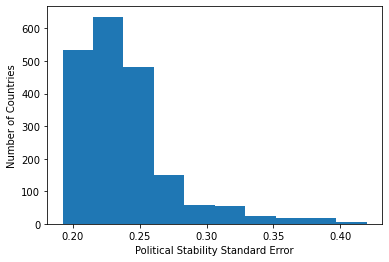

In [451]:
#plot histogram of the Standard Error
import matplotlib.pyplot as plt

plt.hist(PT_new_df['Political_Stability_SE'])
PT_new_df['Political_Stability_SE'].describe()
plt.xlabel("Political Stability Standard Error")
plt.ylabel("Number of Countries")
plt.show()

The dataset now only includes countries with max standard error in the dataset of 0.42.

In [452]:
#Sort the dataset on the 10 year mean political stability values from highest to lowest
grouped_PT_df.sort_values('Political_Stability', ascending=False)

,country,date,Political_Stability,Political_Stability_SE,lat,lon
71,Greenland,2014.5,1.903959,0.382400,77.619235,-42.812597
105,Liechtenstein,2014.5,1.480630,0.269135,47.141631,9.553153
132,New Zealand,2014.5,1.457606,0.216898,-41.500083,172.834408
91,"Jersey, Channel Islands",2015.0,1.399630,0.485580,49.185217,-2.109048
163,Singapore,2014.5,1.374209,0.216898,1.357107,103.819499
107,Luxembourg,2014.5,1.373999,0.225906,49.815868,6.129675
6,Anguilla,2014.5,1.371491,0.300646,18.195495,-63.075023
4,Andorra,2014.5,1.370702,0.314217,42.540717,1.573203
178,Switzerland,2014.5,1.336026,0.220719,46.798562,8.231974
191,Tuvalu,2014.5,1.327352,0.313759,-8.640521,179.158292


The top five countries with high political stability estimates are Greenland (1.9), Liechtenstein, New Zealand, Jersey, Channel Islands, and Singapore.  The lowest political stability estimates are Iraq, Syrian Arab Republic, Pakistan, Afghanistan and Somalia (-2.59). The United States has a ten-year mean political stability score of around 0.5.

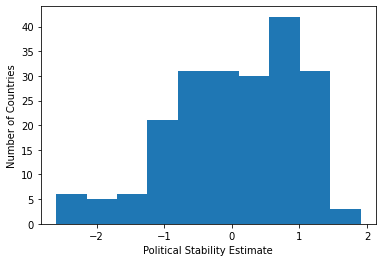

In [453]:
#Show a histogram of 5-year mean political stability. 
plt.hist(x="Political_Stability", data=grouped_PT_df)
plt.xlabel("Political Stability Estimate")
plt.ylabel("Number of Countries")
plt.show()

# Graph the Political Stability Values on a Map

To graph countries' political stability scores and represent them on a world map, we used the cartopy and geopandas packages. Cartopy's shapereader function allowed us to access information on country borders. This provided the data needed to create the outline of a world map. Shapereader converted this data to a shape file that could be read by Geopandas. Geopandas works like Pandas but is able to read spatial data that Pandas cannot. 

It was necessary to rename a few countries in the grouped political stability dataframe to match the names used in the shape file before passing it into Geopandas. For instance, "United States" was renamed "United States of America." Additionally, some countries had to be excluded because they appeared to be missing from the shape file. These had names that could easily have differed between sources (e.g., "Bahamas, The" vs. "Bahamas" or "The Bahamas"), but we were unable to find any variations of these countries' names in the shape file.

Once the data has been read by Geopandas, it can also be plotted using Matplotlib, which has a built-in color map. For the legend, we also layered a scatter plot underneath the color map, and added a color bar representing political stability scores.

In [454]:
#Change names of several countries to match the country name listed in the geopandas shapefile
modified_country_df = grouped_PT_df
boolean_condition = grouped_PT_df.country == 'United States'
column_name = 'country'
new_value = 'United States of America'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Russian Federation'
column_name = 'country'
new_value = 'Russia'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Venezuela, RB'
column_name = 'country'
new_value = 'Venezuela'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Syrian Arab Republic'
column_name = 'country'
new_value = 'Syria'
modified_country_df.loc[boolean_condition, column_name] = new_value

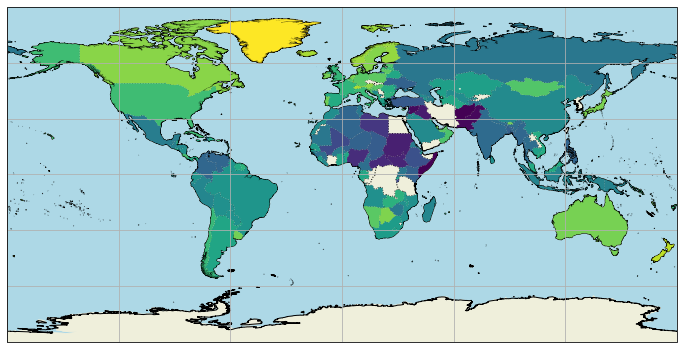

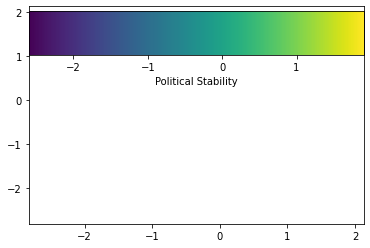

In [455]:
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Set up the canvas
fig = plt.figure(figsize=(12, 12))
central_lon = 0 
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_lon))
ax.gridlines()

# Add borders, ocean, and land features
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
ax.add_feature(cartopy.feature.LAND)
ax.coastlines(resolution='10m')

# Define the list of countries we want to map
countries = modified_country_df['country']

#Define the political stability values for each country
ps = modified_country_df['Political_Stability']

# Normalise the political stability values to between 0 and 1 to extract the colour
ps_norm = (ps-np.nanmin(ps))/(np.nanmax(ps) - np.nanmin(ps))

# Choose the colormap
cmap = plt.cm.get_cmap('viridis')

#loop through each country and political stability value and plot them
for country, ps_norm in zip(countries, ps_norm):
    # read the borders of the country in this loop
    #Exclude some countries whose names are not in the geopandas shapefile
    exclude_list = ['Bahamas, The', 'Brunei Darussalam', "Cote d'Ivoire", "Czech Republic", "Eswatini", "French Guiana", "Gambia, The", "Hong Kong SAR, China", "Jersey, Channel Islands", "Kyrgyz Republic", "Lao PDR", "Macao SAR, China", "Martinique", "Netherlands Antilles", "North Macedonia", "Reunion", "Sao Tome and Principe", "Serbia", "Slovak Republic", "St. Kitts and Nevis", "St. Lucia", "St. Vincent and the Grenadines", "Taiwan, China", "Tanzania", "Timor-Leste", "Virgin Islands (U.S.)", "West Bank and Gaza"]
    if country not in exclude_list:
        poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(ps_norm)
        # plot the country on a map
        ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1)

# Add a scatter plot of the original data so the colorbar has the correct numbers.
#fig, ax = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [2, 1]})
fig, ax = plt.subplots()

dummy_scat = ax.scatter(ps, ps, c=ps, cmap=cmap, zorder=0)
dummy_scat.set_visible(False)
axins1 = inset_axes(ax,
                    width="100%",  
                    height="20%", 
                    loc='upper center')
fig.colorbar(mappable=dummy_scat, label='Political Stability', orientation='horizontal', cax=axins1)
  

In [456]:
#Try to find the name of the countries in the shapefile that are in the exclude list above
newdf = df.loc[(df.ADMIN == "Gaza")]
newdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,GEOU_DIF,GEOUNIT,GU_A3,SU_DIF,SUBUNIT,SU_A3,BRK_DIFF,NAME,NAME_LONG,BRK_A3,BRK_NAME,BRK_GROUP,ABBREV,POSTAL,FORMAL_EN,FORMAL_FR,NAME_CIAWF,NOTE_ADM0,NOTE_BRK,NAME_SORT,NAME_ALT,MAPCOLOR7,MAPCOLOR8,MAPCOLOR9,MAPCOLOR13,POP_EST,POP_RANK,GDP_MD_EST,POP_YEAR,LASTCENSUS,GDP_YEAR,ECONOMY,INCOME_GRP,WIKIPEDIA,FIPS_10_,ISO_A2,ISO_A3,ISO_A3_EH,ISO_N3,UN_A3,WB_A2,WB_A3,WOE_ID,WOE_ID_EH,WOE_NOTE,ADM0_A3_IS,ADM0_A3_US,ADM0_A3_UN,ADM0_A3_WB,CONTINENT,REGION_UN,SUBREGION,REGION_WB,NAME_LEN,LONG_LEN,ABBREV_LEN,TINY,HOMEPART,MIN_ZOOM,MIN_LABEL,MAX_LABEL,NE_ID,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry


# Get Predictor Variables from Sustainability Goals Dataset

With the same method we used for the political stability data, we pulled the sustainability goals data from our database with ETL code and converted it into a Pandas dataframe. We had simplified many of the column headings while extracting the data to the postgresql server, so we changed the headings back. This  also necessitated resetting "country" and "date" as the indexes.

In [457]:
# Connecting to the database (set a new connection)
conn = psycopg2.connect("dbname=sustain_data user=postgres password=122516")
cursor = conn.cursor
sql = "select * from sus_df;"
query_results = pd.read_sql_query(sql, conn)
DF_data = pd.DataFrame(query_results)
conn = None

In [458]:
DF_data.head()

,country,date,forest_area,cereal_yield,current_account_balance,foreign_direct_investment,net_assistance_and_aid,access_clean_fuels,access_electricity,renewable_electricity_output,co2_emissions,air_pollution,mammal_species_threatened,population_in_slums,water_stress,renewable_freshwater_resources,terrestrial_protected_areas,commercial_bank_branches,broad_money_growth,inflation,account_ownership_financial_institution,account_ownership_financial_institution_female,research_development_expenditure,new_business_density,investment_in_energy,investment_in_clean_water,individuals_using_internet,exports_of_goods_annual_growth,exports_of_goods,imports_of_goods_annual_growth,gdp,gdp_growth,gdp_per_capita,gdp_per_capita_growth,literacy_rate_youth_female,literacy_rate_adult_total,school_enrollment_preprimary,school_enrollment_primary_and_secondary_gpi,lower_secondary_completion_rate,educational_attainment_post_secondary_female,educational_attainment_bachelor,adolescents_out_of_school,total_alcohol_consumption_per_capita,prevalence_anemia_among_women,prevalence_hiv,mortality_rate_under_5,mortality_cvd_cancer_diabetes,mortality_rate_neonatal,people_using_basic_drinking_water,people_using_safely_managed_drinking_water,female_genital_mutilation_prevalence,prevalence_underweight_children_under_five,suicide_mortality_rate,high_health_care_expenditure,unemployment,moderate_severe_food_insecurity,women_married_by_age_18,urban_population_growth,battle_related_deaths,intentional_homicides_per_pop
0,Arab World,2019,NaN,NaN,NaN,1.278438,NaN,NaN,89.512282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.445,NaN,1.091848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.814895,45.259266,3.371903,2.811182e+12,1.524176,6570.174197,-0.378386,80.490181,73.114250,27.489100,0.94940,69.715271,NaN,NaN,17.759020,NaN,33.216667,0.118759,34.668926,22.270511,16.749340,NaN,NaN,NaN,NaN,4.180325,NaN,10.207223,NaN,NaN,2.385471,NaN,NaN
1,Arab World,2018,2.849036,2011.461649,NaN,1.258055,NaN,NaN,88.306324,NaN,4.438716,NaN,248.0,31.055925,NaN,NaN,5.282139,11.140,NaN,2.458142,NaN,NaN,NaN,NaN,NaN,NaN,63.166728,8.586482,46.937310,6.308093,2.758001e+12,2.136538,6568.984052,0.212491,80.350563,72.869087,27.001801,0.94833,68.632538,NaN,NaN,18.611620,0.618598,33.047851,0.118937,35.353896,22.416848,16.984326,NaN,NaN,NaN,NaN,4.212684,NaN,10.256579,NaN,NaN,2.414030,20934.0,NaN
2,Arab World,2017,2.868595,1869.677439,NaN,1.230380,NaN,NaN,89.623427,NaN,4.528351,100.0,NaN,NaN,9039.206074,274.77863,5.282139,11.375,NaN,1.966826,37.165211,25.635403,NaN,NaN,NaN,NaN,49.967438,2.300198,43.924685,7.485572,2.511065e+12,1.005611,6095.663430,-0.931400,84.292107,75.766823,27.128111,0.94445,67.786507,NaN,NaN,19.582741,NaN,32.959280,0.119103,35.979010,22.483395,17.208523,88.632153,NaN,NaN,NaN,4.179462,NaN,10.718294,NaN,NaN,2.473679,37279.0,NaN
3,Arab World,2016,2.887384,1705.274933,NaN,1.360062,NaN,84.510733,88.504261,NaN,4.570308,100.0,NaN,31.347130,NaN,NaN,4.949559,11.955,NaN,2.068840,NaN,NaN,NaN,NaN,NaN,NaN,41.487477,3.101272,40.208961,-5.520507,2.461967e+12,3.385842,6093.331009,1.335081,83.529694,74.840797,26.884230,0.94254,66.960098,NaN,NaN,19.566681,NaN,32.879304,0.118929,36.754884,22.867304,17.457540,88.417719,NaN,NaN,NaN,4.258030,NaN,10.507661,NaN,NaN,2.576060,58959.0,NaN
4,Arab World,2015,2.904999,2057.438839,NaN,1.043033,NaN,84.171596,87.935479,2.920702,4.617964,100.0,NaN,NaN,NaN,NaN,NaN,11.300,NaN,1.814077,NaN,NaN,NaN,NaN,NaN,NaN,43.696335,4.329734,43.589983,-3.449783,2.513208e+12,3.395407,6346.032347,1.273220,81.132004,73.499390,26.873301,0.94494,66.659332,NaN,NaN,20.199051,0.627500,32.878107,0.119083,37.551259,23.262936,17.722882,87.936832,NaN,NaN,NaN,4.333516,NaN,10.713793,NaN,NaN,2.695668,68181.0,3.8


In [459]:
DF_data.set_index(['country', 'date'], inplace=True)

In [460]:
print(DF_data.columns.values.tolist())

['forest_area', 'cereal_yield', 'current_account_balance', 'foreign_direct_investment', 'net_assistance_and_aid', 'access_clean_fuels', 'access_electricity', 'renewable_electricity_output', 'co2_emissions', 'air_pollution', 'mammal_species_threatened', 'population_in_slums', 'water_stress', 'renewable_freshwater_resources', 'terrestrial_protected_areas', 'commercial_bank_branches', 'broad_money_growth', 'inflation', 'account_ownership_financial_institution', 'account_ownership_financial_institution_female', 'research_development_expenditure', 'new_business_density', 'investment_in_energy', 'investment_in_clean_water', 'individuals_using_internet', 'exports_of_goods_annual_growth', 'exports_of_goods', 'imports_of_goods_annual_growth', 'gdp', 'gdp_growth', 'gdp_per_capita', 'gdp_per_capita_growth', 'literacy_rate_youth_female', 'literacy_rate_adult_total', 'school_enrollment_preprimary', 'school_enrollment_primary_and_secondary_gpi', 'lower_secondary_completion_rate', 'educational_attain

In [461]:
list1 = []
def list_cols(df, listx):
    for col in df.columns:
        listx.append(col)
    return listx

In [462]:
list_cols(DF_data, list1)

['forest_area',
 'cereal_yield',
 'current_account_balance',
 'foreign_direct_investment',
 'net_assistance_and_aid',
 'access_clean_fuels',
 'access_electricity',
 'renewable_electricity_output',
 'co2_emissions',
 'air_pollution',
 'mammal_species_threatened',
 'population_in_slums',
 'water_stress',
 'renewable_freshwater_resources',
 'terrestrial_protected_areas',
 'commercial_bank_branches',
 'broad_money_growth',
 'inflation',
 'account_ownership_financial_institution',
 'account_ownership_financial_institution_female',
 'research_development_expenditure',
 'new_business_density',
 'investment_in_energy',
 'investment_in_clean_water',
 'individuals_using_internet',
 'exports_of_goods_annual_growth',
 'exports_of_goods',
 'imports_of_goods_annual_growth',
 'gdp',
 'gdp_growth',
 'gdp_per_capita',
 'gdp_per_capita_growth',
 'literacy_rate_youth_female',
 'literacy_rate_adult_total',
 'school_enrollment_preprimary',
 'school_enrollment_primary_and_secondary_gpi',
 'lower_secondary_c

In [463]:
list2 = ['Forest area (% of land area)',
 'Cereal yield (kg per hectare)',
 'Current account balance (% of GDP)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Net official development assistance and official aid received (current US$)',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Access to electricity (% of population)',
 'Renewable electricity output (% of total electricity output)',
 'CO2 emissions (metric tons per capita)',
 'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
 'Mammal species, threatened',
 'Population living in slums (% of urban population)',
 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
 'Renewable internal freshwater resources per capita (cubic meters)',
 'Terrestrial protected areas (% of total land area)',
 'Commercial bank branches (per 100,000 adults)',
 'Broad money growth (annual %)',
 'Inflation, consumer prices (annual %)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)', 'Research and development expenditure (% of GDP)',
 'New business density (new registrations per 1,000 people ages 15-64)',
 'Investment in energy with private participation (current US$)',
 'Investment in water and sanitation with private participation (current US$)',
 'Individuals using the Internet (% of population)',
 'Exports of goods and services (annual % growth)',
 'Exports of goods and services (% of GDP)',
 'Imports of goods and services (annual % growth)',
 'GDP (current US$)',
 'GDP growth (annual %)',
 'GDP per capita (current US$)',
 'GDP per capita growth (annual %)',
 'Literacy rate, youth female (% of females ages 15-24)',
 'Literacy rate, adult total (% of people ages 15 and above)',
 'School enrollment, preprimary (% gross)',
 'School enrollment, primary and secondary (gross), gender parity index (GPI)',
 'Lower secondary completion rate, total (% of relevant age group)',
 'Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)',
 "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
 'Adolescents out of school (% of lower secondary school age)',
 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
 'Prevalence of anemia among women of reproductive age (% of women ages 15-49)',
 'Prevalence of HIV, total (% of population ages 15-49)',
 'Mortality rate, under-5 (per 1,000 live births)', 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
 'Mortality rate, neonatal (per 1,000 live births)',
 'People using at least basic drinking water services (% of population)',
 'People using safely managed drinking water services (% of population)',
 'Female genital mutilation prevalence (%)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Suicide mortality rate (per 100,000 population)',
 'Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%)',
 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
 'Prevalence of moderate or severe food insecurity in the population (%)',
 'Women who were first married by age 18 (% of women ages 20-24)',
 'Urban population growth (annual %)',
 'Battle-related deaths (number of people)',
 'Intentional homicides (per 100,000 people)']


In [464]:
dict_cols = {}
def create_dict(keys, vals):
    for key in keys:
        for value in vals:
            dict_cols[key] = value
            vals.remove(value)
            break

In [465]:
create_dict(list1, list2)

In [466]:
dict_cols

{'forest_area': 'Forest area (% of land area)',
 'cereal_yield': 'Cereal yield (kg per hectare)',
 'current_account_balance': 'Current account balance (% of GDP)',
 'foreign_direct_investment': 'Foreign direct investment, net inflows (% of GDP)',
 'net_assistance_and_aid': 'Net official development assistance and official aid received (current US$)',
 'access_clean_fuels': 'Access to clean fuels and technologies for cooking (% of population)',
 'access_electricity': 'Access to electricity (% of population)',
 'renewable_electricity_output': 'Renewable electricity output (% of total electricity output)',
 'co2_emissions': 'CO2 emissions (metric tons per capita)',
 'air_pollution': 'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
 'mammal_species_threatened': 'Mammal species, threatened',
 'population_in_slums': 'Population living in slums (% of urban population)',
 'water_stress': 'Level of water stress: freshwater withdrawal as a proportio

In [467]:
def rename_cols(df, dictx):
    df.rename(columns=dictx, inplace=True)

In [468]:
rename_cols(DF_data, dict_cols)

In [469]:
DF_data.head()

Forest area (% of land area)  Cereal yield (kg per hectare)  \
country    date                                                                
Arab World 2019                           NaN                            NaN   
           2018                      2.849036                    2011.461649   
           2017                      2.868595                    1869.677439   
           2016                      2.887384                    1705.274933   
           2015                      2.904999                    2057.438839   

                 Current account balance (% of GDP)  \
country    date                                       
Arab World 2019                                 NaN   
           2018                                 NaN   
           2017                                 NaN   
           2016                                 NaN   
           2015                                 NaN   

                 Foreign direct investment, net inflows (% of GDP)  \
country    date                                                      
Arab World 2019                                           1.278438   
           2018                                           1.258055   
           2017                                           1.230380   
           2016                                           1.360062   
           2015                                           1.043033   

                 Net official development assistance and official aid received (current US$)  \
country    date                                                                                
Arab World 2019                                                NaN                             
           2018                                                NaN                             
           2017                                                NaN                             
           2016                                                NaN                             
           2015                                                NaN                             

                 Access to clean fuels and technologies for cooking (% of population)  \
country    date                                                                         
Arab World 2019                                                NaN                      
           2018                                                NaN                      
           2017                                                NaN                      
           2016                                          84.510733                      
           2015                                          84.171596                      

                 Access to electricity (% of population)  \
country    date                                            
Arab World 2019                                89.512282   
           2018                                88.306324   
           2017                                89.623427   
           2016                                88.504261   
           2015                                87.935479   

                 Renewable electricity output (% of total electricity output)  \
country    date                                                                 
Arab World 2019                                                NaN              
           2018                                                NaN              
           2017                                                NaN              
           2016                                                NaN              
           2015                                           2.920702              

                 CO2 emissions (metric tons per capita)  \
country    date                                           
Arab World 2019                                     NaN   
           2018                                4.438716   
           2017                                4.528351  

## Merging Political Stability and Sustainability Goals Dataframes

The next step was to join the two dataframes to allow for analysis of how sustainability goals correspond with political stability. Pandas has a merge function that works like a SQL join statement. We used an inner merge/join to combine the political stability and sustainability dataframes on the indexes "country" and "date."

In [470]:
#Use pd.merge to do an inner join of political and sustainability DFs on "country" and "date".
merged_inner = pd.merge(left=DF_data, right=PT_new_df, on=['country', 'date'])
#Since it's an inner join, this automatically removes rows for which the country/date pairs don't appear in both tables.  

print(merged_inner.shape)
merged_inner.head()

(1927, 65)


,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,2019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,2018,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0

In [471]:
merged_inner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 1926
Data columns (total 65 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype  
---  ------                                                                                                                           --------------  -----  
 0   country                                                                                                                          1927 non-null   object 
 1   date                                                                                                                             1927 non-null   int64  
 2   Forest area (% of land area)                                                                                                     1703 non-null   float64
 3   Cereal yield (kg per hectare)                                                                     

### Preprocessing

For machine learning models to  work properly, we needed to convert all non-numeric values to numeric values. "Date" was original stored as string objects, so we used pd.to_datetime to convert it to datetime format, then used datetime to format the dates to only include years, without month, day, or time information. Contries were also converted from strings to categorical data and then label encoded as integers. Because there were 194 countries, it was not feasible to lust all of them out in a dictionary for label encoding, and manual entry also would have increased the risk of error. To resolve this, we used the map function within a dictionary to generate label values for all of the country keys.

The next step in preprocessing was to drop columns that we knew we did not need. These included latitude and longitude, which we had added to the Political Stability dataframe during the initial ETL coding. We only needed those features for creating the map of political stability scores, so they were no longer of use. We also dropped "id" because it was redundant with "country," and "date" because we were only focusing on sustainability factors as explanatory variables and this did not need currently need date information for our machine learning models. However, we did use date information in some later analyses, so the earlier step of converting date format was still necessary. Even before merging the data frames, we had already done a small amount of preprocessing by removing countries with high standard errors for their political stability scores. The political stability standard error column was no longer needed after that step, so we removed it at this point, as well. 

In [472]:
#Convert "date" column from string object to datetime format.
merged_inner["date"] = pd.to_datetime(merged_inner["date"])
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,1970-01-01 00:00:00.000002019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,1970-01-01 00:00:00.000002018,1.850994,2164.9,-21.231682,0.65073

In [473]:
#Convert "date" column to only show year.
import datetime as dt
merged_inner["date"]=merged_inner["date"].dt.year
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,1970,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,1970,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0

In [474]:
country_count = merged_inner['country'].nunique()
print(country_count)
country_list = merged_inner['country'].unique()
print(country_list)

194
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Costa Rica' "Cote d'Ivoire" 'Croatia'
 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland'
 'Grenada' 'Guam' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israe

In [475]:
#Convert "country" column from regular string object to categorical.
country_labels = merged_inner['country'].astype('category').cat.categories.tolist()

#create map/dictionary for label encoding.
replace_map_country = {'country' : {k: v for k,v in zip(country_labels,list(range(1,len(country_labels)+1)))}}

print(replace_map_country)

{'country': {'Afghanistan': 1, 'Albania': 2, 'Algeria': 3, 'American Samoa': 4, 'Andorra': 5, 'Angola': 6, 'Antigua and Barbuda': 7, 'Argentina': 8, 'Armenia': 9, 'Aruba': 10, 'Australia': 11, 'Austria': 12, 'Azerbaijan': 13, 'Bahamas, The': 14, 'Bahrain': 15, 'Bangladesh': 16, 'Barbados': 17, 'Belarus': 18, 'Belgium': 19, 'Belize': 20, 'Benin': 21, 'Bermuda': 22, 'Bhutan': 23, 'Bolivia': 24, 'Bosnia and Herzegovina': 25, 'Botswana': 26, 'Brazil': 27, 'Brunei Darussalam': 28, 'Bulgaria': 29, 'Burkina Faso': 30, 'Burundi': 31, 'Cabo Verde': 32, 'Cambodia': 33, 'Cameroon': 34, 'Canada': 35, 'Cayman Islands': 36, 'Central African Republic': 37, 'Chad': 38, 'Chile': 39, 'China': 40, 'Colombia': 41, 'Comoros': 42, 'Costa Rica': 43, "Cote d'Ivoire": 44, 'Croatia': 45, 'Cuba': 46, 'Cyprus': 47, 'Czech Republic': 48, 'Denmark': 49, 'Djibouti': 50, 'Dominica': 51, 'Dominican Republic': 52, 'Ecuador': 53, 'El Salvador': 54, 'Equatorial Guinea': 55, 'Eritrea': 56, 'Estonia': 57, 'Eswatini': 58, '

In [476]:
#Create a copy of the merged_inner df so that we still have a version with country names and IDs.
merged_encoded = merged_inner.copy()

In [477]:
#Label encode all countries by mapping the corresponding dictionary values (integers) onto the keys (country names).
merged_encoded.replace(replace_map_country, inplace=True)

In [478]:
#Drop the ID column since it is repetitive since we already have a country column
#Drop date column since we don't need it for the machine learning model
#Drop the Political_Stability_SE column, since that was only useful for finding countries where the estimate of political stability had a lot of error
#Drop lat and lon columns since they were only useful for mapping, but we don't need them for the model.
columns_to_drop = ['id','lat','lon','date','Political_Stability_SE']
merged_encoded.drop(columns_to_drop, axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,NaN,NaN,1.8353

Before filling or removing any null values, we were interested in exploring a possible correlation between abundance of null values and political instability. It seemed plausible that a nation with a very unstable government and/or high rates of violence and terrorism might not have adequate government infrastructure in place to submit complete annual statistics to the World Bank.

Since "Political Stability and Absence of Violence/Terrorism" is our dependent variable, we first confirmed that there were no missing or null values in that column. Then we used a lambda function to generate a new column and fill it with the total NaN counts from each row. We calculated the correlation coefficient for political stability and NaN count, but the resulting correlation was low: 0.20. Additionally, it was a positive correlation, which was unexpected. We had thought it more likely that the countries with many NaN values would have low political stability.

In [479]:
#Confirm that there are no null/NaN values in the "Political_Stability" column.
merged_encoded['country'].isnull().values.any()

False

In [300]:
#Find number of null values in each row.
#merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

In [480]:
#Add a column for number of NaN/null values in each row.
merged_encoded['NaN_count'] = merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

In [481]:
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability,NaN_count
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407,37
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,N

In [482]:
#Calculate and print correlation coefficient for "Political_Stability" and "NaN_count" columns.
nan_pol_corr = merged_encoded["Political_Stability"].corr(merged_encoded["NaN_count"])
print(nan_pol_corr)
#The resulting correlation coefficient is low.

0.2027688453557994


After exploring the NaN value counts as an independent variable, we dropped the NaN count column and worked on filling or removing null and missing values. Because there were multiple rows for each country (corresponding to the other index, year, in the original data set), we determined that the most practical way to fill null values was to group rows by country and use each country's nearest yearly value for every feature to fill any missing values. 

We also dropped all feature columns in which more than 30% of countries had missing values. Seventy percent seemed like the minimum acceptable number of actual values to be able to use a feature as an independent variable and trust that our analyses could be reasonably accurate.

These steps condensed our dataframe to 1,927 rows and 46 columns.

In [483]:
#Since the correlation is low between NaN values and Political Stability score, we can drop the NaN column now. 
merged_encoded.drop('NaN_count', axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,NaN,NaN,1.8353

In [484]:
#Fill missing values with the specific country's available data  
filled_df = merged_encoded.groupby('country').apply(lambda x : x.ffill().bfill())

In [485]:
filled_df.head()


,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,70.699997,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,NaN,0.211648,190490000.0,NaN,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,NaN,NaN,0.21,42.6,0.1,60.3,35.3,35.9,67.064623,NaN,NaN,19.1,4.1,14.631331,10.98,60.8,28.3,3.323827,29940.0,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.0501

In [299]:
#Find number of null values in each row.
#filled_df.apply(lambda x: x.isna().sum(), axis=1)

In [486]:
#Find the number of null values per feature
filled_df.isnull().sum()

country                                                                                                                               0
Forest area (% of land area)                                                                                                         31
Cereal yield (kg per hectare)                                                                                                       208
Current account balance (% of GDP)                                                                                                  168
Foreign direct investment, net inflows (% of GDP)                                                                                    88
Net official development assistance and official aid received (current US$)                                                         578
Access to clean fuels and technologies for cooking (% of population)                                                                160
Access to electricity (% of population)         

In [487]:
#Drop all features with more than 30% of the countries having missing values
limit = len(filled_df) * .70
filled_df_new = filled_df.dropna(thresh=limit, axis=1)
filled_df_new.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4

In [488]:
filled_df_new.shape

(1927, 46)

In [298]:
#Find number of null values in each row.
#filled_df_new.apply(lambda x: x.isna().sum(), axis=1)

# What feature correlates best with Political Stability?

To pinpoint the features that correlate most closely with political stability, we ran Pearson's R correlation coefficients for each explanatory variable, then sorted them in descending order and selected the first 3 features and last three features. We defined these as the top three positive and top three negative correlations, respectively. We scatter-plotted the feature with the strongest correlation, "Account Ownership at a Financial Institution, female (% of population)," on the x-axis and political stability on the y-axis, then added a line of best fit.

Political_Stability                                                                                                        1.000000
Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)    0.665655
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)            0.643513
Individuals using the Internet (% of population)                                                                           0.562367
Name: Political_Stability, dtype: float64
Mortality rate, neonatal (per 1,000 live births)                               -0.561199
Adolescents out of school (% of lower secondary school age)                    -0.550472
Net official development assistance and official aid received (current US$)    -0.541900
Prevalence of anemia among women of reproductive age (% of women ages 15-49)   -0.525195
Name: Political_Stability, dtype: float64


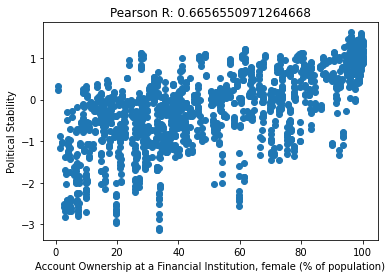

In [489]:
#get all correlations from filled_df_new dataframe
correlations = filled_df_new.corr()
#Select top 3 positive and negative correlations with political stability
top_3_pos_corrs = correlations['Political_Stability'].sort_values(ascending=False).head(4)
top_3_neg_corrs = correlations['Political_Stability'].sort_values(ascending=True).head(4)

#print out top correlations
print(top_3_pos_corrs)
print(top_3_neg_corrs)

#Set best_corr_value
best_corr_value = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)'].corr(filled_df_new['Political_Stability'])

#graph top correlation
#set x and y for scatterplot
x = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)']
y = filled_df_new['Political_Stability']

#Use scatterplot
plt.scatter(x, y)
#add title
plt.title('Pearson R: ' + str(best_corr_value))
plt.xlabel("Account Ownership at a Financial Institution, female (% of population)")
plt.ylabel("Political Stability")
plt.show()

Text(0.5, 1.0, 'Pearson R: 0.6656550971264668')

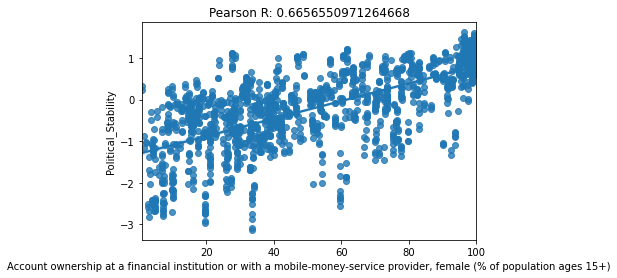

In [490]:
#Make plot using Seaborn which adds best fit line
import seaborn as sns
sns.regplot(x='Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
           y='Political_Stability', data=filled_df_new).set_title('Pearson R: ' + str(best_corr_value))

# Find Features that are correlated with each other and drop features 

To remove redundant features, we created a correlation matrix and heatmap and used them to locate pairs of features that had greater than 0.8 correlation coefficients. We then dropped one of the feature from each of these highly correlated pairs. However, before performing this step, it was useful to fill in missing values in some columns with data calculated from other columns that had a correlation coefficient greater than 0.7.

In [491]:
#make a copy of filled_df_new
corr_filled_df = filled_df_new.copy()
corr_filled_df.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4

In [64]:
#Find column pairs where correlation is greater than 0.7 and fill in missing values using the correlated column
for i in range(len(filled_df_new.columns)):
    for j in range(i):
        corr=filled_df_new[filled_df_new.columns[i]].corr(filled_df_new[filled_df_new.columns[j]])
        if corr > 0.7:
            col1_vals = filled_df_new[filled_df_new.columns[i]].values
            col2_vals = filled_df_new[filled_df_new.columns[j]].values
            for index1, col1_val in enumerate(col1_vals):
                if np.isnan(col1_val) and not np.isnan(col2_vals[index1]):
                    for index2, col2_val in enumerate(col2_vals):
                        if abs(col2_val-col2_vals[index1]) < (0.1*col2_vals[index1]) and not np.isnan(col1_vals[index2]) and index2 != index1:
                            col1_val = col1_vals[index2] 
            corr_filled_df[corr_filled_df.columns[i]] = col1_vals.tolist()

corr_filled_df.head()
                    

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Tax revenue (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,9.898451,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,9.898451,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,9.898451,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,9.502653,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6

In [492]:
#Find the number of null values per feature
corr_filled_df.isnull().sum()

country                                                                                                                      0
Forest area (% of land area)                                                                                                31
Cereal yield (kg per hectare)                                                                                              208
Current account balance (% of GDP)                                                                                         168
Foreign direct investment, net inflows (% of GDP)                                                                           88
Net official development assistance and official aid received (current US$)                                                578
Access to clean fuels and technologies for cooking (% of population)                                                       160
Access to electricity (% of population)                                                                        

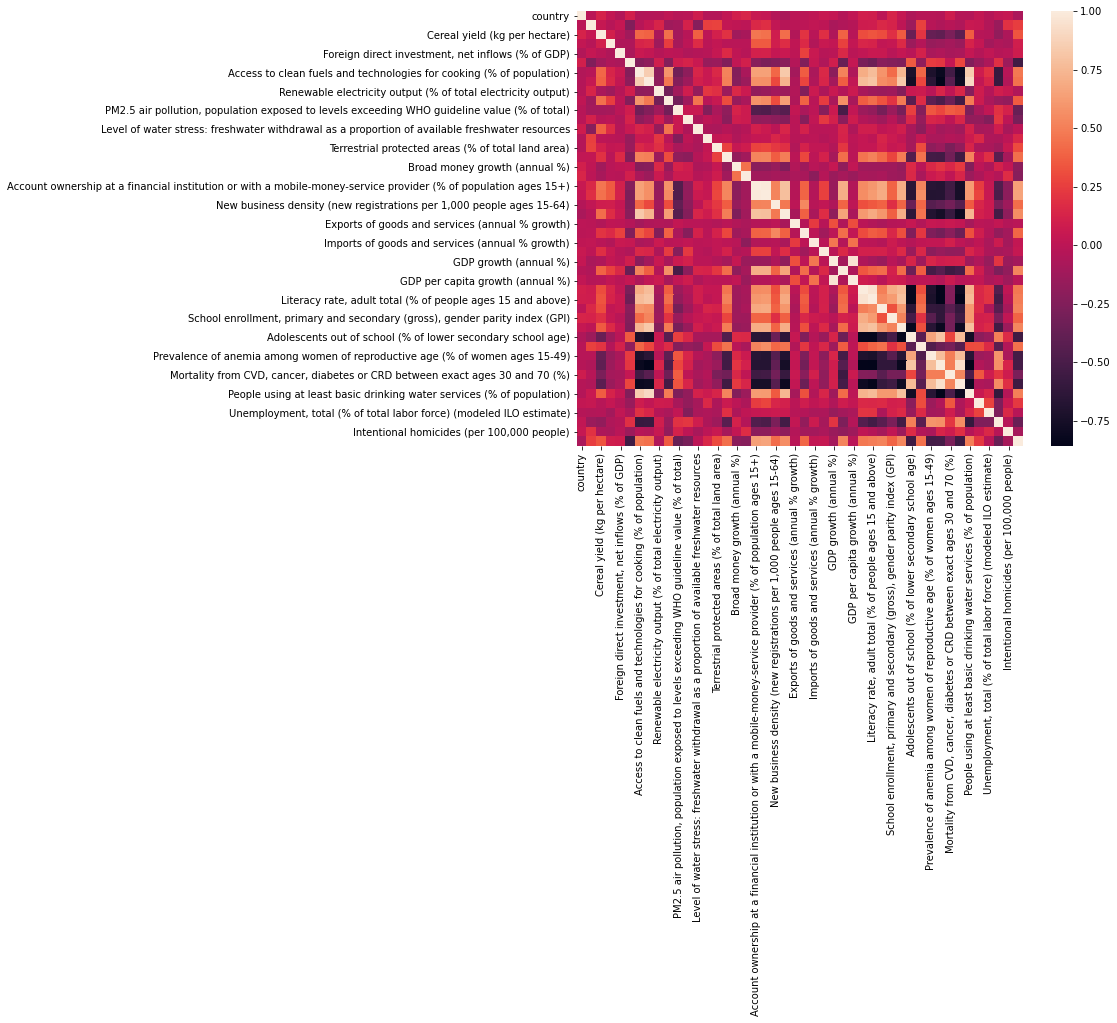

In [493]:
#Create Correlation Matrix
CorrMatrix = filled_df_new.corr()

#plot using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(CorrMatrix)
plt.show()

<ipython-input-494-0ce77629f95e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))


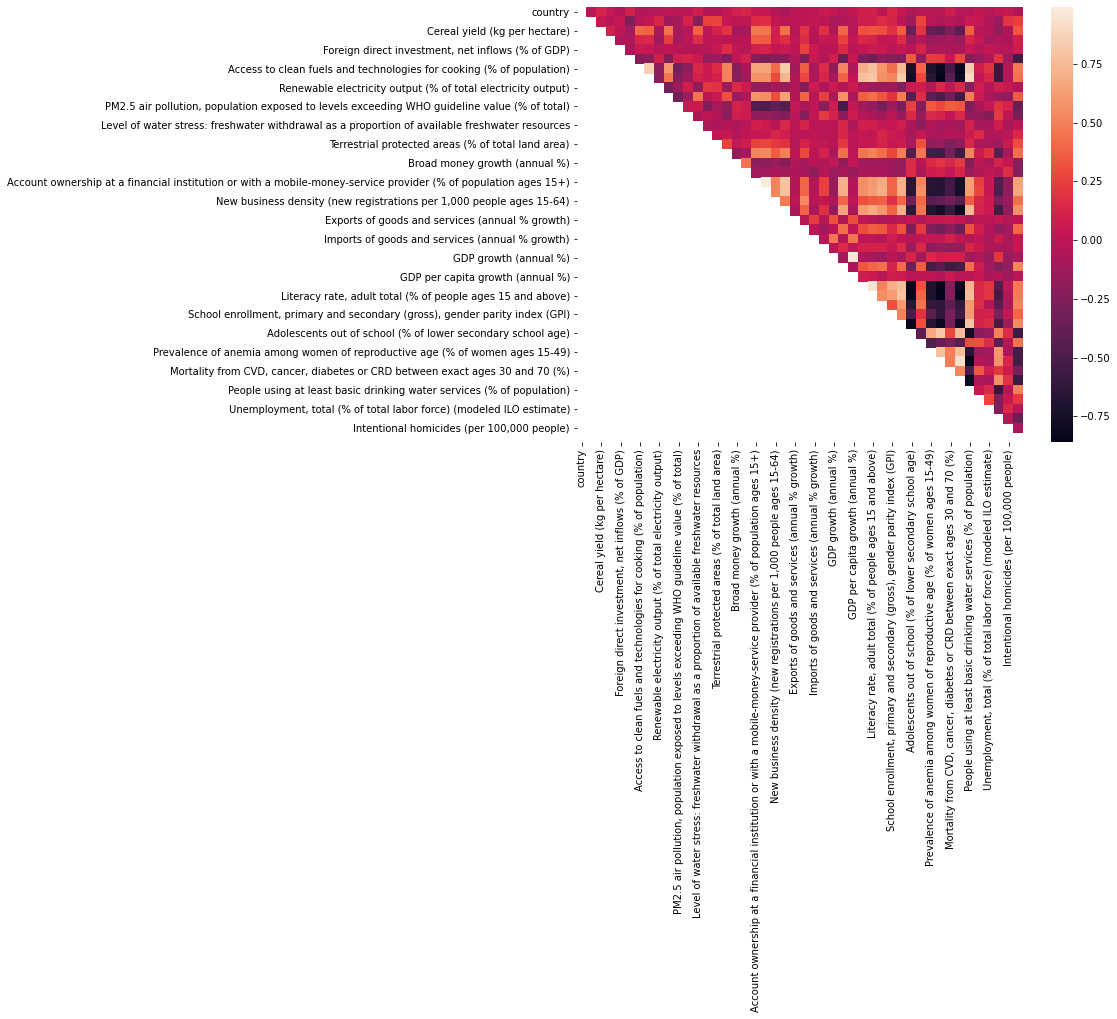

In [494]:
#Drop one feature if there is a high correlation
#import datasets from sklearn
from sklearn import datasets

#Get upper triangle of the correlation matrix since the bottom triangle is the same
upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))

plt.figure(figsize=(10,8))
sns.heatmap(upper_matrix)
plt.show()


In [495]:
#Identify columns to drop where the correlation is greater than 0.8
to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.8)]
print(to_drop)

['Access to electricity (% of population)', 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)', 'Individuals using the Internet (% of population)', 'GDP per capita growth (annual %)', 'Literacy rate, adult total (% of people ages 15 and above)', 'Lower secondary completion rate, total (% of relevant age group)', 'Mortality rate, under-5 (per 1,000 live births)', 'Mortality rate, neonatal (per 1,000 live births)', 'People using at least basic drinking water services (% of population)']


In [496]:
#Drop the highly correlated columns from filled_df_new
df_uncorr = corr_filled_df.drop(to_drop, axis=1)
df_uncorr.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,0.211648,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,56.254749,NaN,0.63602,NaN,0.21,42.6,35.3,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,0.211648,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,56.254749,NaN,0.63602,NaN,0.21,41.8,35.4,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,0.154862,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,56.254749,NaN,0.64169,NaN,0.21,40.9,35.5,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,0.130028,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,56.254749,NaN,0.64567,NaN,0.21,40.2,35.6,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,86.050111,0.232176,100.0,11.0,54.757019,1299.037244,0.100000,2.16,3.079022,-0.661709,14.893312,0.124470,NaN,NaN,NaN,1.990711e+10,1.451315,578.466353,56.254749,NaN,0.64233,NaN,0.21,39.4,35.6,4.0,11.39,3.951726,9.783922,-2.571222


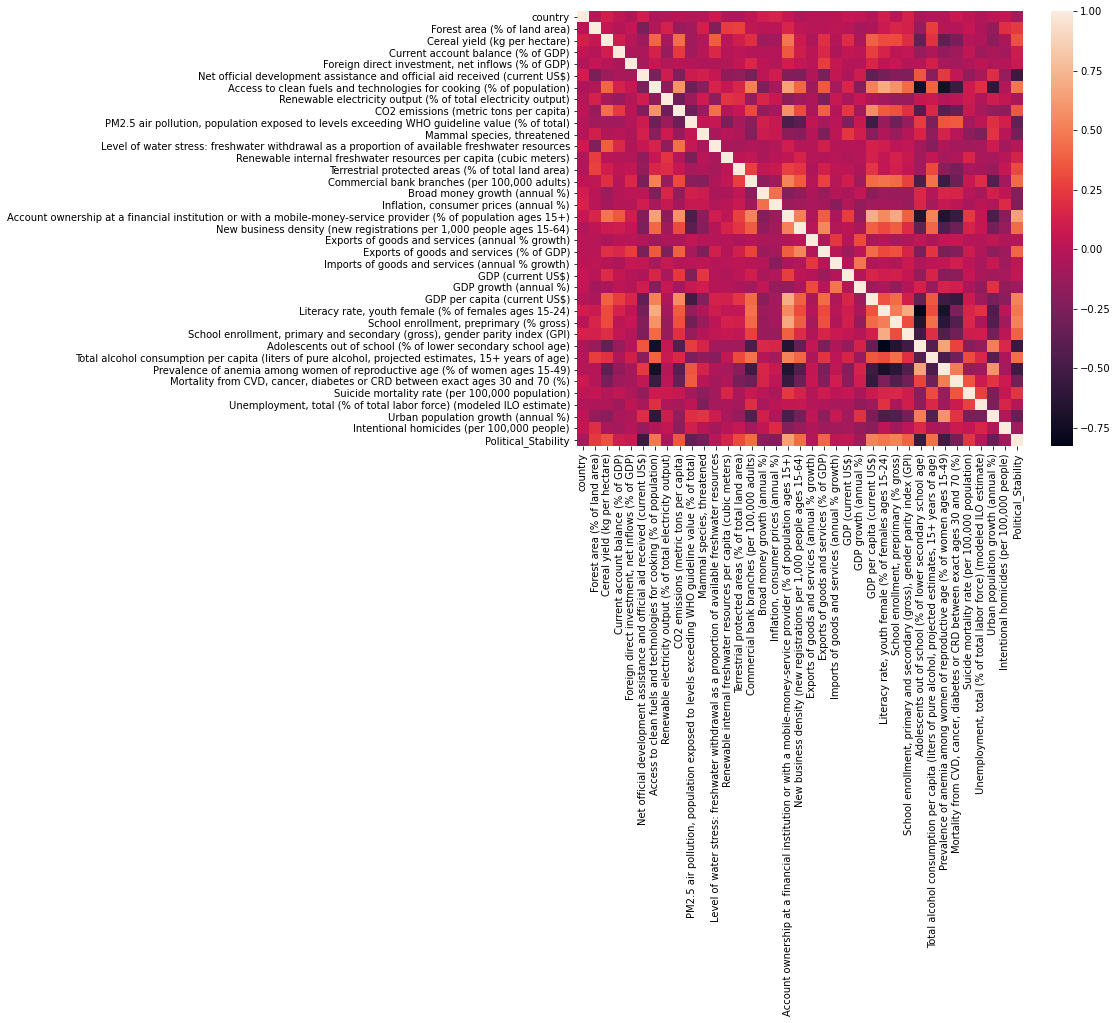

In [497]:
#Look at new correlation Matrix
new_corr_matrix = df_uncorr.corr()

plt.figure(figsize=(10,8))
sns.heatmap(new_corr_matrix)
plt.show()

# Use Unsupervised Learning to fill in remaining missing values after Clustering like countries

More preprocessing was needed to prepare the data for unsupervised learning. We dropped all rows containing more than 30% missing values, then searched for columns with high numbers of missing values and dropped those, as well. A few columns that we wanted to investigate had to be removed temporarily for the same reason, but we stored these in a list so that they could be added back later. The final columns we dropped were "Political Stability," which is the response variable, and "country," which will be the target for our cluster model. At this point we set all remaining columns as the features for the cluster model and specified "country" as the target. 

We filled in any values that were still missing in the UL feature set with the means of those columns' other values and then confirmed that no missing values remained. As a final preprocessing step, we normalized the data using StandardScaler.

In [498]:
print(df_uncorr.shape)
#drop rows with more than 30% of the features missing in that row
threshold=0.7*df_uncorr.shape[1]
print(threshold)
mod_df = df_uncorr.dropna(axis=0, thresh=threshold)

print(mod_df.shape)
#print(mod_df['country'].value_counts())

(1927, 37)
25.9
(1769, 37)


In [499]:
#Find the number of null values per feature
mod_df.isnull().sum()

country                                                                                                              0
Forest area (% of land area)                                                                                         0
Cereal yield (kg per hectare)                                                                                       90
Current account balance (% of GDP)                                                                                  80
Foreign direct investment, net inflows (% of GDP)                                                                   20
Net official development assistance and official aid received (current US$)                                        450
Access to clean fuels and technologies for cooking (% of population)                                                40
Renewable electricity output (% of total electricity output)                                                         0
CO2 emissions (metric tons per capita)          

In [500]:
#A couple of columns still have high values for missing data, so we can drop those
new_drop_cols = ['Net official development assistance and official aid received (current US$)']
mod_df.drop(new_drop_cols, axis=1, inplace=True)
mod_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1769, 36)

In [501]:
#remove features that have a lot of missing values that we want to fill in later using unsupervised learning
cols_to_impute = ['Cereal yield (kg per hectare)', 'Current account balance (% of GDP)', 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', 'Renewable internal freshwater resources per capita (cubic meters)', 'Broad money growth (annual %)', 'Inflation, consumer prices (annual %)', 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)', 'New business density (new registrations per 1,000 people ages 15-64)', 'Exports of goods and services (annual % growth)', 'Exports of goods and services (% of GDP)', 'Imports of goods and services (annual % growth)', 'Literacy rate, youth female (% of females ages 15-24)', 'School enrollment, preprimary (% gross)', 'School enrollment, primary and secondary (gross), gender parity index (GPI)', 'Adolescents out of school (% of lower secondary school age)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Intentional homicides (per 100,000 people)']
df_cols_to_impute = mod_df[cols_to_impute]
df_cols_to_impute.head()

#set the features for the unsupervised learning model
features = mod_df.drop(cols_to_impute, axis=1)
features.drop('Political_Stability', axis=1, inplace=True)
features.drop('country', axis=1, inplace=True)

#set the target for the unsupervised learning model
y = mod_df['country']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: country, dtype: int64

In [502]:
#fill in missing values in the features df with mean of column values
features.fillna(features.mean(), inplace=True)

In [503]:
#make sure there are no missing values
features.isnull().sum()

Forest area (% of land area)                                                                            0
Foreign direct investment, net inflows (% of GDP)                                                       0
Access to clean fuels and technologies for cooking (% of population)                                    0
Renewable electricity output (% of total electricity output)                                            0
CO2 emissions (metric tons per capita)                                                                  0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)            0
Mammal species, threatened                                                                              0
Terrestrial protected areas (% of total land area)                                                      0
Commercial bank branches (per 100,000 adults)                                                           0
GDP (current US$)                             

In [504]:
#standardize the dataset
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
features_sc = sc.fit_transform(features)

We decided to build a K-means cluster model first because it would allow us to fill in missing values for the features we planned to add back into the dataframe. First, we created a K-means model to iterate through different values of k and generate a list of inertias, which would help with evaluating distance of data points from cluster centers. These were used in conjunction to create an elbow graph of cluster count versus inertia. We determined that the inertia started to decrease in a more linear fashion around 11 clusters, which suggested that 11 would be the ideal number of clusters for the K-means model. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


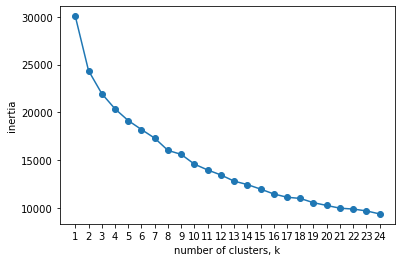

In [505]:
#Perform k-Means to cluster the data

#Find number of clusters using inertia
from sklearn.cluster import KMeans

ks = range(1, 25)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(features_sc)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Based on the elbow graph, we created an instance of the K-means model and specified 11 clusters. Then we fit the preprocessed, scaled features we selected for UL to this model. This defined cluster labels 1-11 and assigned a label to each row in the data set. We created a new column for cluster labels, as well. (Note: the inertia graph pictured above changed slightly when a feature could no longer be accessed by the World Bank dataset and we had not yet stored our data in a local database.  The results of the models below were obtained by using all of the original data and unsupervised learning that contained 11 clusters.  However, based on the graph above, if I were to rerun all the models without the feature that could no longer be accessed, I would not pick 11 clusters because it looks like the "elbow" would be closer to 7-8 clusters in the above figure.)

At this point, we were able to add in the dropped features that we still wanted to investigate. We grouped rows by cluster number and and used a lambda function to fill in missing values in those feature columns with the means of values from similar rows (i.e., rows in the same cluster) and transform to create a dataframe with those transformed values.

In [506]:
#set number of clusters to 11 using inertia elbow method
from sklearn.cluster import KMeans
model = KMeans(n_clusters=11)
labels = model.fit_predict(features_sc)

In [507]:
#add cluster label to features dataset
features['cluster_label']=labels.tolist()
features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),cluster_label
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,2
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2


In [508]:
#join features dataset with df_cols_to_impute
final_features = pd.concat([features,df_cols_to_impute], axis=1)
final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),cluster_label,Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,0.154862,NaN,NaN,NaN,56.254749,NaN,0.64169,NaN,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,2,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,0.130028,NaN,NaN,NaN,56.254749,NaN,0.64567,NaN,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,0.124470,NaN,NaN,NaN,56.254749,NaN,0.64233,NaN,11.39,9.783922


In [509]:
#Group by label and fill missing values using mean of each group for each feature
filled_final_features = final_features.groupby("cluster_label").transform(lambda x: x.fillna(x.mean()))
filled_final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,0.211648,10.225015,34.267275,2.015196,56.254749,36.384077,0.63602,29.222249,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,0.211648,10.225015,34.267275,2.015196,56.254749,36.384077,0.63602,29.222249,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,0.154862,10.225015,34.267275,2.015196,56.254749,36.384077,0.64169,29.222249,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,0.130028,10.225015,34.267275,2.015196,56.254749,36.384077,0.64567,29.222249,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,0.124470,10.225015,34.267275,2.015196,56.254749,36.384077,0.64233,29.222249,11.39,9.783922


In our final check for null values, we found 18 NaNs in the column "New business density (new registrations per 1,000 people ages 15-64)." This must have been caused by a cluster that contained all null values for that feature. We dropped this column, reapplied our fillna function, and confirmed that no cells containing missing values remained. Finally, we added our response variable, "Political Stability" back into the final dataframe.

In [510]:
#make sure there are no missing values
filled_final_features.isnull().sum()

Forest area (% of land area)                                                                                        0
Foreign direct investment, net inflows (% of GDP)                                                                   0
Access to clean fuels and technologies for cooking (% of population)                                                0
Renewable electricity output (% of total electricity output)                                                        0
CO2 emissions (metric tons per capita)                                                                              0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)                        0
Mammal species, threatened                                                                                          0
Terrestrial protected areas (% of total land area)                                                                  0
Commercial bank branches (per 100,000 adults)           

In [511]:
#New business density column must have had all null values for one cluster, so it was unable to be filled in. Since that had a large number of missing values earlier, let's drop that column. 
filled_final_features.drop('New business density (new registrations per 1,000 people ages 15-64)', axis=1, inplace=True)

In [633]:
filled_final_features = filled_final_features.apply(lambda x: x.fillna(x.mean()),axis=0)
#make sure there are no missing values
filled_final_features.isnull().sum()

Forest area (% of land area)                                                                                       0
Foreign direct investment, net inflows (% of GDP)                                                                  0
Access to clean fuels and technologies for cooking (% of population)                                               0
Renewable electricity output (% of total electricity output)                                                       0
CO2 emissions (metric tons per capita)                                                                             0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)                       0
Mammal species, threatened                                                                                         0
Terrestrial protected areas (% of total land area)                                                                 0
Commercial bank branches (per 100,000 adults)                   

In [634]:
#create a final df, combining the response and predictor variables
filled_final_df = filled_final_features.copy()
filled_final_df['Political_Stability'] = mod_df['Political_Stability'].copy()
filled_final_df.Political_Stability = filled_final_df.Political_Stability.astype(float)
filled_final_df.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",Political_Stability
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,10.225015,34.267275,2.015196,56.254749,36.384077,0.63602,29.222249,10.98,6.655561,-2.649407
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,10.225015,34.267275,2.015196,56.254749,36.384077,0.63602,29.222249,11.06,6.655561,-2.751611
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,10.225015,34.267275,2.015196,56.254749,36.384077,0.64169,29.222249,11.18,6.678401,-2.800609
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,10.225015,34.267275,2.015196,56.254749,36.384077,0.64567,29.222249,11.31,6.551163,-2.671054
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,10.225015,34.267275,2.015196,56.254749,36.384077,0.64233,29.222249,11.39,9.783922,-2.571222


# Supervised Learning Models

## Mutiple Linear Regression Model
We tried several supervised learning models, beginning with multiple linear regression. A regression model made sense because we were working with continuous data. We defined X as all of the predictor variables and y as the response variable, then split the data into training and test sets and standardized it using StandardScaler.

We fit the training data set to a linear regression model, then compared the trained model's predicted y values to the actual y values in the test set.

Because a classification report is only for categorical data, we decided to evaluate our models using root mean squared error, R2 score, and mean absolute error. For our multiple linear regression model, the RMSE and MAE were not low enough (ideally it would be very close to 0), which meant that the level of error in predicting new data values was too high. The R2 score, which measures the correlation between the model's predicted y values and the actual y values in the test data, was too low. It should be closer to 1.

In [422]:
#Set X and y for the models
X = filled_final_features.copy()
print(X.shape)
y = mod_df['Political_Stability'].copy()
print(y.shape)

#import train test split
from sklearn.model_selection import train_test_split

#split the dataset into testing and training portions, with the testing portion making up 20% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

(1769, 33)
(1769,)


In [426]:
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [419]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Multiple Linear Regression RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Multiple Linear Regression Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Multiple Linear Regression Mean Absolute Error =', round(np.mean(errors), 2))

Multiple Linear Regression RMSE_Model =  0.61
Multiple Linear Regression Score =  0.53
Multiple Linear Regression Mean Absolute Error = 0.46


## Decision Tree Regressor

We ran multiple tree-based models, as well. A decision tree regression model was created and fitted to the training data set, then run to create a y prediction variable. The regression tree searched for splits that would produce leaves in which the mean values in the leaves and the mean target variables were as close as possible to each other. For a regression tree, MSE and  RMSE of the targets are commonly used to measure the impurity of nodes. 

Initially, we ran the decision tree model using the default parameters, but the RMSE was very high, and the other scores were not ideal, either. Next, we created a grid of hyperparameters and ran a grid search model to test them. This allowed us to locate the best hyperparameters in the grid, tune the decision tree regression model by inputting these hyperparameters, and run it again. RMSE and MAE were lower for the tuned model, and R2 score was higher, but the scores still were not very good. 

Using an enumerate function, we iterated through feature importances of the tuned decision tree regression model results and found the four most important features:
* Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)
* Adolescents out of school (% of lower secondary school age)
* Mammal species, threatened
* Level of water stress: freshwater withdrawal as a proportion of available freshwater resources

A plot of feature importances shows that "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)" was far and away the most important feature, according to the tuned decision tree model.

In [420]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Decision Tree RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

Decision Tree RMSE_Model =  0.71
Decision Tree R2 Score =  0.35
Decision Tree Mean Absolute Error = 0.43


In [89]:
#Tune Decision Tree Regressor
#get parameters of model
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [114]:
#Tune the model to reduce error

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8, 0.1, 0.2]}

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtr,param_grid=params_dt, cv=10, n_jobs=-1)

# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=11, max_features=0.8,
                                             min_samples_leaf=0.005),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 0.1, 0.2],
                         'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06,
                                              0.08]})

In [115]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 11, 'max_features': 0.8, 'min_samples_leaf': 0.005}


In [373]:
#fit the model again with the best parameters
dtr = DecisionTreeRegressor(max_depth=11, max_features=0.8, min_samples_leaf=0.005, random_state=42)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Tuned Decision Tree RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Tuned Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Tuned Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

Tuned Decision Tree RMSE_Model =  0.56
Tuned Decision Tree R2 Score =  0.61
Tuned Decision Tree Mean Absolute Error = 0.38


Feature: 0, Score: 0.00212
Feature: 1, Score: 0.00346
Feature: 2, Score: 0.01493
Feature: 3, Score: 0.00904
Feature: 4, Score: 0.00210
Feature: 5, Score: 0.00468
Feature: 6, Score: 0.08483
Feature: 7, Score: 0.03147
Feature: 8, Score: 0.03243
Feature: 9, Score: 0.01424
Feature: 10, Score: 0.00186
Feature: 11, Score: 0.00586
Feature: 12, Score: 0.00729
Feature: 13, Score: 0.01964
Feature: 14, Score: 0.00227
Feature: 15, Score: 0.03307
Feature: 16, Score: 0.01231
Feature: 17, Score: 0.00392
Feature: 18, Score: 0.00256
Feature: 19, Score: 0.08285
Feature: 20, Score: 0.03828
Feature: 21, Score: 0.00372
Feature: 22, Score: 0.00122
Feature: 23, Score: 0.38084
Feature: 24, Score: 0.00109
Feature: 25, Score: 0.04007
Feature: 26, Score: 0.00045
Feature: 27, Score: 0.00064
Feature: 28, Score: 0.01557
Feature: 29, Score: 0.03618
Feature: 30, Score: 0.07783
Feature: 31, Score: 0.02677
Feature: 32, Score: 0.00642


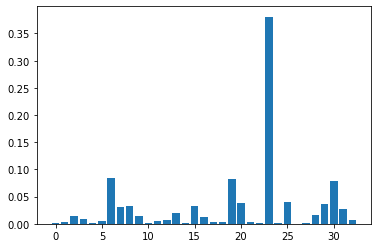

In [122]:
#Find what features are the most important for this model
importance = dtr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [124]:
#Show column name for most important columns
print(X.columns[23])
print(X.columns[30])
print(X.columns[6])
print(X.columns[19])

Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)
Adolescents out of school (% of lower secondary school age)
Mammal species, threatened
Level of water stress: freshwater withdrawal as a proportion of available freshwater resources


## Random Forest Regressor

To try to improve on the accuracy of the decision tree regression results, we implemented a random forest regression model. In the first run, we specified that the model should include 10 decision trees. The results were improved (lower RMSE and MAE, higher R2), but they still were not a high as we were aiming. The RMSE and MAE in particular remained too high.

We took feature importance levels from this model, as well, and plotted them. The bar plot again indicates that our top feature, "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)" is by far the most important.
* Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)
* Mammal species, threatened
* Adolescents out of school (% of lower secondary school age)
* GDP (current US $)

In [372]:
#import model
from sklearn.ensemble import RandomForestRegressor

#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=10, random_state=42)

# Fit the model to the training set
rf.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Random Forest Regression RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Mean Absolute Error =', round(np.mean(errors), 2))

Random Forest Regression RMSE_Model =  0.43
Random Forest Regression R2 Score =  0.76
Mean Absolute Error = 0.31


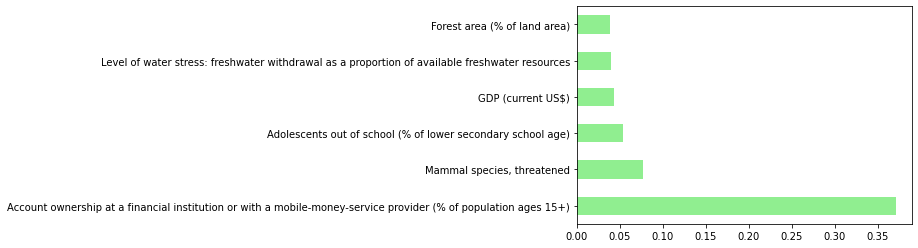

In [246]:
#Look at feature importances for this model
new_df = pd.DataFrame(X, X.columns)

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = new_df.columns)
# Sort importances_rf        
sorted_importances_rf = importances_rf.sort_values(ascending=False) 
#Only save top five important features
top_sorted_importances_rf = sorted_importances_rf[0:6]
# Make a horizontal bar plot
top_sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

In [234]:
#Get parameters for the Random Forest Regressor
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

To tune the random forest model, we used a randomized grid search to test a number of different hyperparameters. First, we set up a list comprehension to iterate through different numbers of decision trees. It tested 10 random tree counts in the range of 200 to 2,000. The settings for the maximum number of features to consider at each split were log base 2 of the total number of features, square root of the total number of features, and the total number of features, unaltered. Among other settings, we set the minimum number of samples required at node at 1 and higher (1, 2, and 4). The search also tried selecting samples with and without bootstrapping. The randomized grid search was fit to the training data and then run across 100 combinations, using three-fold cross-validation.

best_params_ identified the ideal parameters for the random forest model (800 trees, 1 sample minimum per leaf, no bootstrapping, etc.). We ran the random forest regression model again, this time tuned to the best parameters found by the random grid search. The scores improved somewhat, especially the R2 score, but we wanted to try other models to try and further improve the results.
* Random Forest Regression RMSE_Model =  0.35
* Random Forest Regression R2 Score =  0.84
* Mean Absolute Error = 0.27

In [235]:
#tune the model

#import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2','auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [236]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs=None)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(min_samples_leaf=0.12,
                                                   n_estimators=400,
                                                   random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'auto',
                                                         'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
        

In [237]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [371]:
#Rerun the models with the selected best parameters
#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False, random_state=42)

# Fit the model to the training set
rf.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Random Forest Regression RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Mean Absolute Error =', round(np.mean(errors), 2))

Random Forest Regression RMSE_Model =  0.35
Random Forest Regression R2 Score =  0.84
Mean Absolute Error = 0.27


In [257]:
#Use a function to see how much the best parameters improved the model from its base state with 10 estimators and all default parameters.
def evaluate(rf, X_test, y_test):
    y_pred = rf.predict(X_test)
    errors = abs(y_pred - y_test)
    mae = round(np.mean(errors),2)
    print('Mean Absolute Error = ', round(mae,2))
    
    return mae


base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_mae = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_mae = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (base_mae - random_mae) / base_accuracy))

Mean Absolute Error =  0.31
Mean Absolute Error =  0.27
Improvement of 0.08%.


The tuned random forest model found the same top four most important features, but in a slightly different order. As in all previous tests, though, "Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)" was the top feature, but this time the difference between this feature's importance ond the next one was not as pronounced.	

In [258]:
#Create a dataframe of the feature importances
rf_features_df = pd.DataFrame(rf.feature_importances_, X.columns)
rf_features_df.head()

,0
Forest area (% of land area),0.031359
"Foreign direct investment, net inflows (% of GDP)",0.011832
Access to clean fuels and technologies for cooking (% of population),0.045566
Renewable electricity output (% of total electricity output),0.013356
CO2 emissions (metric tons per capita),0.029790


In [259]:
rf_features_df.sort_values(by=0, ascending=False)

,0
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),0.097263
GDP per capita (current US$),0.073355
"Mammal species, threatened",0.065644
Adolescents out of school (% of lower secondary school age),0.065552
Prevalence of anemia among women of reproductive age (% of women ages 15-49),0.059932
Access to clean fuels and technologies for cooking (% of population),0.045566
"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",0.043521
GDP (current US$),0.039665
"School enrollment, preprimary (% gross)",0.037854
"Suicide mortality rate (per 100,000 population)",0.036036


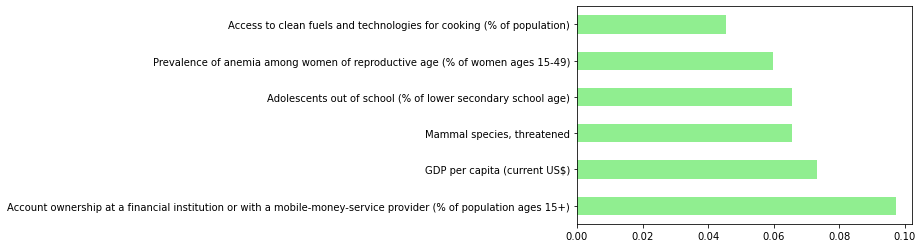

In [262]:
#Look at feature importances for this model

# Create a pd.Series of features importances
importances_rf_tuned = pd.Series(rf.feature_importances_, index=new_df.columns)
# Sort importances_rf        
sorted_importances_rf = importances_rf_tuned.sort_values(ascending=False) 
#Only save top five important features
top_sorted_importances_rf = sorted_importances_rf[0:6]
# Make a horizontal bar plot
top_sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

# PCA

We ran principal component analysis on the data and retried some of the models to see if dimensionality reduction had any effect. However, the decision tree and the random forest models both produced worse scores when used in conjunction with PCA.

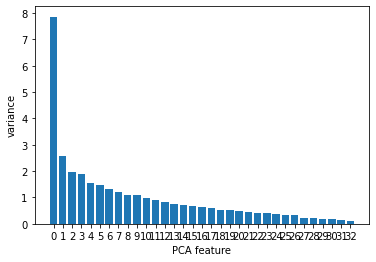

In [263]:
#import PCA
from sklearn.decomposition import PCA

#find the 
pca = PCA()

#train the model
pca.fit(X_train)

#find the intrinsic dimension of the dataset
features = range(pca.n_components_)

#graph variance in each feature
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [370]:
# Perform Dimension Reduction with PCA
pca = PCA(n_components=4)

X_train_pca=pca.fit(X_train)
X_test_pca=pca.fit(X_test)

X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

#fit the decision tree model with the PCA transformed data
dtpca = DecisionTreeRegressor(max_depth=11, max_features=0.8, min_samples_leaf=0.005, random_state=42).fit(X_train_transformed, y_train)

#make predictions with the model
y_pred = dtpca.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PCA Decision Tree RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PCA Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('PCA Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

PCA Decision Tree RMSE_Model =  0.62
PCA Decision Tree R2 Score =  0.52
PCA Decision Tree Mean Absolute Error = 0.43


In [293]:
#tune the decision tree with the PCA transformed data

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],'min_samples_leaf': [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8, 0.1, 0.2]}

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtpca,param_grid=params_dt, cv=10, n_jobs=-1)

# Fit 'grid_dt' to the training data
grid_dt.fit(X_train_transformed, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=11, max_features=0.8,
                                             min_samples_leaf=0.005,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 0.1, 0.2],
                         'min_samples_leaf': [0.001, 0.005, 0.01, 0.02, 0.04,
                                              0.06, 0.08]})

In [294]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 9, 'max_features': 0.8, 'min_samples_leaf': 0.005}


In [369]:
#fit the decision tree model with the PCA transformed data
dtpca_tuned = DecisionTreeRegressor(max_depth=9, max_features=0.8, min_samples_leaf=0.005, random_state=42).fit(X_train_transformed, y_train)

#make predictions with the model
y_pred = dtpca_tuned.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PCA Decision Tree RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PCA Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('PCA Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

PCA Decision Tree RMSE_Model =  0.63
PCA Decision Tree R2 Score =  0.49
PCA Decision Tree Mean Absolute Error = 0.44


## Random Forest Regressor with PCA

In [367]:
#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False, random_state=42)

# Fit the model to the training set
rf.fit(X_train_transformed, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Random Forest Regression RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Mean Absolute Error =', round(np.mean(errors), 2))

Random Forest Regression RMSE_Model =  0.54
Random Forest Regression R2 Score =  0.63
Mean Absolute Error = 0.38


For both Random Forest and Decision PCA made the model results worse.  

## XGBoost Regressor

We tried an ensemble method, XGBoost regression, next. With the default parameters, this method returned results similar to those of the other tree-based models. Another grid-based search found the best hyperparameters to be 900 samples, a learning_rate of 0.06, and a maximum tree depth of 4 branches or splits. The results of the XGBoost regression were almost as good as the tuned random forest regression.

In [366]:
#import XGBRegressor
from xgboost import XGBRegressor

#Instantiate the model
xgbr = XGBRegressor()

#fit the model to the training data
xgbr.fit(X_train, y_train)

#make predictions from the test dataset
y_pred = xgbr.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("XGBoost Regressor RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('XGBoost Regressor R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('XGBoost Regressor Mean Absolute Error =', round(np.mean(errors), 2))


XGBoost Regressor RMSE_Model =  0.42
XGBoost Regressor R2 Score =  0.78
XGBoost Regressor Mean Absolute Error = 0.31


In [302]:
# Get parameters from the model
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [315]:
# tune the model's hyperparameters. 
params_xgbr = {'n_estimators': [500, 600, 700, 800, 900],
             'max_depth': [4, 6, 8, 10],
             'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07]}

# Instantiate 'grid_xgbr'
grid_xgbr = GridSearchCV(estimator=xgbr,
                       param_grid=params_xgbr, 
                       cv=3,
                       scoring='neg_mean_squared_error',                       
                       verbose=1,                       
                       n_jobs=-1)

grid_xgbr.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=8,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
      

In [316]:
# Extract best hyperparameters from 'grid_xgbr'
best_hyperparams = grid_xgbr.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 900}


In [365]:
# Instantiate a XGBoostRegressor 'xgbr' using best hyperparameters
xgbr_best = XGBRegressor(learning_rate=0.05,                                  
                    max_depth=6,                                                                 
                    n_estimators=900,
                    random_state=42)
# Fit 'xgbr' to the training set
xgbr_best.fit(X_train, y_train)
# Predict the test set labels
y_pred = xgbr_best.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Tuned XGBoost Regressor RMSE_Model = ", round(rmse, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Tuned XGBoost Regressor R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Tuned XGBoost Regressor Mean Absolute Error =', round(np.mean(errors), 2))

Tuned XGBoost Regressor RMSE_Model =  0.38
Tuned XGBoost Regressor R2 Score =  0.81
Tuned XGBoost Regressor Mean Absolute Error = 0.28


I had better results when using the best parameters from the first time I ran the GridSearchCV, so I decided to keep those.  If I change them to the parameters listed above, the rmse goes up, the R2 score goes down, and the mean absolute error goes up.  

## PyTorch Neural Network Model

For the PyTorch neural network model, we encoded the training and testing data into float tensors and created a class for our model. For deep learning, we included five layers of perceptrons (i.e., simpler models) as attributes: an input layer, three hidden layers, and an output layer. Each perceptron's result was passed into the next activation function, so at each step, the model was further tuned to minimize errors. 

We used the loss function MSEloss to calculate the difference between test data values and the predicted values in our model's output. The model was optimized using the Adam optimization algorithm, which works like stochastic gradient descent but accelerates it toward the minima, minimizes the effect of outliers, and reduces the MSEloss function.

We set the gradient to zero, performed backward propagation, and ran one optimization step at each epoch. The model ran through 500 epochs (i.e., iterations), each time further reducing the loss function and passing its output into the model again. By epoch 491, the MSE loss was only ~0.0016. Next we made predictions with the PyTorch model and compared these with the actual test data values. The results were the best so far out of all the supervised learning methods:
* PyTorch Neural Network RMSE_Model =  0.29
* PyTorch Neural Network R2 Score =  0.9
* PyTorch Mean Squared Error =  0.08

The mean squared error was especially affected by the combination of the MSE loss function and the Adam optimizer. It is also worth noting that the R2 score reached 0.9.

In [635]:
#Set X and y for the models
X_pytorch = filled_final_df.drop('Political_Stability', axis=1).values
y_pytorch = filled_final_df['Political_Stability'].values.reshape(-1,1)

#split the dataset into testing and training portions, with the testing portion making up 20% of the data.
X_train_pytorch, X_test_pytorch, y_train_pytorch, y_test_pytorch = train_test_split(X_pytorch, y_pytorch, test_size = 0.2, random_state = 42)

In [636]:
sc = StandardScaler()
X_train_pytorch = sc.fit_transform(X_train_pytorch)
X_test_pytorch = sc.fit_transform(X_test_pytorch)

In [637]:
import torch.nn as nn
import torch.nn.functional as F #this has activation functions

# Creating tensors
X_train_pytorch = torch.FloatTensor(X_train_pytorch)
X_test_pytorch = torch.FloatTensor(X_test_pytorch)
X_train_pytorch = X_train_pytorch.float()
X_test_pytorch = X_test_pytorch.float()

y_train_pytorch = torch.FloatTensor(y_train_pytorch)
y_test_pytorch = torch.FloatTensor(y_test_pytorch)
y_train_pytorch = y_train_pytorch.float()
y_test_pytorch = y_test_pytorch.float()

print(X_train_pytorch.shape)
print(y_train_pytorch.shape)
print(X_test_pytorch.shape)
print(y_test_pytorch.shape)

y_train_pytorch = y_train_pytorch.view(-1, 1)
y_test_pytorch = y_test_pytorch.view(-1, 1)
print(y_train_pytorch)

torch.Size([1415, 33])
torch.Size([1415, 1])
torch.Size([354, 33])
torch.Size([354, 1])
tensor([[-0.2371],
        [ 1.1119],
        [ 0.5156],
        ...,
        [ 0.5251],
        [ 0.7283],
        [ 1.4539]])


In [663]:
class ANN_Model(nn.Module):
    def __init__(self, input_features=33, hidden1=300, hidden2=300, hidden3=300, hidden4=300, out_features=1):
        super().__init__()
        self.layer_1_connection = nn.Linear(input_features, hidden1)
        self.layer_2_connection = nn.Linear(hidden1, hidden2)
        self.layer_3_connection = nn.Linear(hidden2, hidden3)
        self.layer_4_connection = nn.Linear(hidden3, hidden4)
        self.out = nn.Linear(hidden4, out_features)
    
    def forward(self, x):
        #apply activation functions
        x = F.relu(self.layer_1_connection(x))
        x = F.relu(self.layer_2_connection(x))
        x = F.relu(self.layer_3_connection(x))
        x = F.relu(self.layer_4_connection(x))
        x = self.out(x)
        return x

In [664]:
torch.manual_seed(4)

#instantiate the model
ann_model = ANN_Model()

In [665]:
# loss function
loss_function = nn.MSELoss()

#set the optimizer
optimizer = torch.optim.Adam(ann_model.parameters(), lr = 0.001)

In [666]:
#run model through multiple epochs/iterations
final_loss = []
n_epochs = 500
for epoch in range(n_epochs):
    #y_pred_pytorch = ann_model.forward(X_train_pytorch)
    y_pred_pytorch = ann_model(X_train_pytorch)
    loss = loss_function(y_pred_pytorch, y_train_pytorch)
    final_loss.append(loss)
    
    if epoch % 10 == 1:
        print(f'Epoch number: {epoch} with loss: {loss.item()}')
    
    optimizer.zero_grad() #zero the gradient before running backwards propagation
    loss.backward() #for backward propagation 
    optimizer.step() #performs one optimization step each epoch

Epoch number: 1 with loss: 0.8228175640106201
Epoch number: 11 with loss: 0.317988783121109
Epoch number: 21 with loss: 0.1770692765712738
Epoch number: 31 with loss: 0.09566344320774078
Epoch number: 41 with loss: 0.07424875348806381
Epoch number: 51 with loss: 0.046414997428655624
Epoch number: 61 with loss: 0.030825724825263023
Epoch number: 71 with loss: 0.023666689172387123
Epoch number: 81 with loss: 0.01738600805401802
Epoch number: 91 with loss: 0.014132263138890266
Epoch number: 101 with loss: 0.0123900743201375
Epoch number: 111 with loss: 0.012861540541052818
Epoch number: 121 with loss: 0.008234957233071327
Epoch number: 131 with loss: 0.0074671730399131775
Epoch number: 141 with loss: 0.007612986024469137
Epoch number: 151 with loss: 0.0068766651675105095
Epoch number: 161 with loss: 0.005252342205494642
Epoch number: 171 with loss: 0.005531586706638336
Epoch number: 181 with loss: 0.0042775883339345455
Epoch number: 191 with loss: 0.018716705963015556
Epoch number: 201 wi

In [667]:
#make predictions with the model
y_pred_pytorch_test = []

with torch.no_grad():
    for i, data in enumerate(X_test_pytorch):
        prediction = ann_model(data)
        #print(prediction)
        y_pred_pytorch_test.append(prediction.item())

#print(y_pred_pytorch_test)
#print(len(y_pred_pytorch_test))

In [671]:
# Calculate the root mean square error
rmse_pytorch = MSE(y_test_pytorch, y_pred_pytorch_test)**(1/2)
print("PyTorch Neural Network RMSE_Model = ", round(rmse_pytorch, 2))

#Get r2 score
r2_pytorch = r2_score(y_test_pytorch, y_pred_pytorch_test)
print('PyTorch Neural Network R2 Score = ' , round(r2_pytorch, 2))

#get mse
mean_square_error_pytorch=MSE(y_test_pytorch, y_pred_pytorch_test)
print('PyTorch Mean Squared Error = ', round(mean_square_error_pytorch,2))

PyTorch Neural Network RMSE_Model =  0.29
PyTorch Neural Network R2 Score =  0.9
PyTorch Mean Squared Error =  0.08


## Keras Neural Network Model

Our data was run through a Keras neural network, too. To create this model, we  first built a function (run_keras_model) to test numerous combinations of parameters. We instiated the model using the sequential API. This made it possible to stack multiple layers. Then, we used if/elif statements to test different numbers of hidden layers (1, 2, 3, and 4). In each case, the input layer and the hidden layer(s) used the Rectified Linear Unit (ReLU) activation function. In compiling the model, either stochastic gradient descent (SGD) or Adam was selected as an optimizer, and the MSE was always set as the loss to be minimized. We set an early stopping monitor so that the model would stop running when the loss function stopped improving. The model was fitted to our training data, and the function was set to return all sets of parameters that returned R2 scores greater than or equal to 0.9.

In [321]:
#import necessary modules
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [424]:
#get the number of columns in the predictors array
n_cols = X_train.shape[1]
print(n_cols)

33


In [404]:
def run_keras_model(learning_rate, nodes_per_layer, num_layers, optimizer):
    
    #instantiate the keras model
    model=Sequential()

    if num_layers == 1:
        #add the layers 
        model.add(Dense(nodes_per_layer, activation='relu', input_shape=(n_cols,)))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(1))
    elif num_layers == 2:
        #add the layers 
        model.add(Dense(nodes_per_layer, activation='relu', input_shape=(n_cols,)))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(1))
    elif num_layers == 3:
        #add the layers 
        model.add(Dense(nodes_per_layer, activation='relu', input_shape=(n_cols,)))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(1))
    elif num_layers == 4:
        #add the layers 
        model.add(Dense(nodes_per_layer, activation='relu', input_shape=(n_cols,)))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(nodes_per_layer, activation='relu'))
        model.add(Dense(1))

    #compile the model
    if optimizer == "SGD":
        model.compile(optimizer=SGD(lr=learning_rate), loss='mean_squared_error')
    elif optimizer == "Adam":
        model.compile(optimizer='adam', loss='mean_squared_error')

    #set an early stopping monitor so that the model will stop running if improvement to the loss function is not seen after a specified number of epochs
    early_stopping_monitor = EarlyStopping(patience=4, verbose=0, restore_best_weights=True)

    #fit the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0, epochs=100, callbacks=[early_stopping_monitor])

    #get the predictions from the model
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mean_square_error=MSE(y_test, y_pred)
    rmse_model = mean_square_error**(0.5)
    
    if r2>=0.9:
    
        print("New model parameters and results")
    
        #print learning rate
        print("Learning Rate = ", learning_rate)
    
        #print nodes_per_layer
        print("Nodes Per Layer = ", nodes_per_layer)
    
        #Print number of hidden layers
        print("Number of Hidden Layers = ", num_layers)
    
        #Print Optimizer
        print("Optimizer = ", optimizer)
    
        #print mse
        print("Keras mean_squared_error = ", round(mean_square_error, 2))

        # Calculate the root mean square error
        print("Keras RMSE_Model = ", round(rmse_model, 2))

        #Get r2 score
        print('Keras R2 Score = ' , round(r2, 2))
    
    return r2, rmse_model, mean_square_error

Outside of the function, we set lists of each variable to test the best parameters, placed the parameters we wanted to test into a dictionary, and created all possible combinations of keys and values from the aliased lists of parameters in the dictionary. Using the run_keras_model function created in the previous step, we tested all of the chosen combinations of parameters. The output of this function was a list of all combinations of parameters with r2 scores greater than or equal to 0.9. The output also displayed the MSE and RMSE for each of these combinations. All of this information was organized into a table for readability. 

In [405]:
#set lists of each variable to test best parameters
lr = [0.001, 0.005, 0.01, 0.05]
num_layers = [1, 2, 3, 4]
nodes_per_layer = [100, 200, 300]
optimizer = ['Adam', 'SGD']

#put the params we want to test into a dictionary
params_keras = {'learning_rate': lr,
             'number_hidden_layers': num_layers,
             'nodes_per_layer': nodes_per_layer,
               'optimizer': optimizer}

#Create all combinations of values from dictionary
import itertools as it

all_values = sorted(params_keras)
combinations = it.product(*(params_keras[key] for key in all_values))
#print(list(combinations))

for item in combinations:
    model_lr = item[0]
    model_nodes = item[1]
    model_layers = item[2]
    model_optimizer = item[3]
    
    run_keras_model(model_lr, model_nodes, model_layers, model_optimizer)

New model parameters and results
Learning Rate =  0.001
Nodes Per Layer =  200
Number of Hidden Layers =  3
Optimizer =  Adam
Keras mean_squared_error =  0.08
Keras RMSE_Model =  0.28
Keras R2 Score =  0.9
New model parameters and results
Learning Rate =  0.001
Nodes Per Layer =  300
Number of Hidden Layers =  3
Optimizer =  Adam
Keras mean_squared_error =  0.08
Keras RMSE_Model =  0.28
Keras R2 Score =  0.9
New model parameters and results
Learning Rate =  0.001
Nodes Per Layer =  300
Number of Hidden Layers =  4
Optimizer =  Adam
Keras mean_squared_error =  0.07
Keras RMSE_Model =  0.27
Keras R2 Score =  0.91
New model parameters and results
Learning Rate =  0.005
Nodes Per Layer =  200
Number of Hidden Layers =  3
Optimizer =  Adam
Keras mean_squared_error =  0.07
Keras RMSE_Model =  0.26
Keras R2 Score =  0.91
New model parameters and results
Learning Rate =  0.005
Nodes Per Layer =  300
Number of Hidden Layers =  2
Optimizer =  Adam
Keras mean_squared_error =  0.08
Keras RMSE_Mode

|Hidden Layers| Nodes Per Layer| Optimizer | Learning Rate| Mean Squared Error| R2 Score |
|---|---|---|---|---|---|
|2 | 100 | Adam  | NA | 0.07 | 0.91|
|2 | 200 | Adam  | NA | 0.08 | 0.9 |
|2 | 300 | Adam | NA | 0.07 | 0.91|
|3 | 200 | Adam | NA | 0.07| 0.91|
|**3** | **300** | **Adam**  | **NA** | **0.07** | **0.92**|
|4 | 200 | Adam  | NA | 0.07 | 0.91|
|4 | 300 | Adam | NA | 0.07 | 0.91|

From the list of parameter combinations with high R2 scores, we selected the best set of parameters to use in our final Keras model. We instantiated the keras model and added three hidden layers, with 300 nodes per layer. Adam was selected as the optimizer. We fit the model to our training data and specified that our testing data would be used for validation.  The model was set to go through 100 epochs but stop early if the MSE loss stopped improving. When we ran the model, it stopped at 20 epochs, at which point it produced the results below (Note: when run with the function, the results were slightly better as seen in the table above, but with each model run, results can vary slightly):
* Keras mean_squared_error =  0.07
* Keras RMSE_Model =  0.27
* Keras R2 Score =  0.91

Each score was slightly better than the corresponding score produced by the PyTorch model.

In [676]:
#Run the best model individually to save y_pred

#instantiate the keras model
model=Sequential()

#add the layers 
model.add(Dense(300, activation='relu', input_shape=(n_cols,)))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping_monitor])

#get the predictions from the model
y_pred = model.predict(X_test)

#Evaluate the model
r2 = r2_score(y_test, y_pred)
mean_square_error=MSE(y_test, y_pred)
rmse_model = mean_square_error**(0.5)

#print mse
print("Keras mean_squared_error = ", round(mean_square_error, 2))

# Calculate the root mean square error
print("Keras RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
print('Keras R2 Score = ' , round(r2, 2))

Epoch 1/100
45/45 [==============================] - 1s 9ms/step - loss: 0.5198 - val_loss: 0.2441
Epoch 2/100
45/45 [==============================] - 0s 6ms/step - loss: 0.1794 - val_loss: 0.1748
Epoch 3/100
45/45 [==============================] - 0s 7ms/step - loss: 0.1059 - val_loss: 0.1066
Epoch 4/100
45/45 [==============================] - 0s 11ms/step - loss: 0.0578 - val_loss: 0.1224
Epoch 5/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0494 - val_loss: 0.1043
Epoch 6/100
45/45 [==============================] - 0s 8ms/step - loss: 0.0400 - val_loss: 0.0995
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0508 - val_loss: 0.1022
Epoch 8/100
45/45 [==============================] - 0s 8ms/step - loss: 0.0386 - val_loss: 0.0927
Epoch 9/100
45/45 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.1048
Epoch 10/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0321 - val_loss: 0.0922
Epoch 11

# Testing for Overfitting and Underfitting

For the Keras model, the model was slightly overfitting because the mean square error (loss) was lower for the training data than for the testing data. However, the difference was not significantly different, so it was doing a relatively good job of fitting the data. Some things that can be done to reduce overfitting are to simplify the model and use early stopping. We tested those below.

In [679]:
#instantiate the keras model
model=Sequential()

#add the layers 
model.add(Dense(300, activation='relu', input_shape=(n_cols,)))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#set an early stopping monitor so that the model will stop running if improvement to the loss function is not seen after a specified number of epochs
early_stopping_monitor = EarlyStopping(patience=4, verbose=0, restore_best_weights=True)

#fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping_monitor])

#get the predictions from the model
y_pred = model.predict(X_test)

#Evaluate the model
r2 = r2_score(y_test, y_pred)
mean_square_error=MSE(y_test, y_pred)
rmse_model = mean_square_error**(0.5)

#print mse
print("Keras mean_squared_error = ", round(mean_square_error, 2))

# Calculate the root mean square error
print("Keras RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
print('Keras R2 Score = ' , round(r2, 2))

Epoch 1/100
45/45 [==============================] - 0s 5ms/step - loss: 0.4263 - val_loss: 0.2980
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.2339 - val_loss: 0.2389
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1481 - val_loss: 0.2157
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1089 - val_loss: 0.1760
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1373 - val_loss: 0.1901
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1631 - val_loss: 0.1417
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1006 - val_loss: 0.1321
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0650 - val_loss: 0.1326
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0938
Epoch 10/100
45/45 [==============================] - 0s 2ms/step - loss: 0.0765 - val_loss: 0.1073
Epoch 11/

Removing two hidden layers to simplify the model did not improve the difference between training and testing mean squared error and reduced the model performance. 

In [682]:
#instantiate the keras model
model=Sequential()

#add the layers 
model.add(Dense(300, activation='relu', input_shape=(n_cols,)))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#set an early stopping monitor so that the model will stop running if improvement to the loss function is not seen after a specified number of epochs
early_stopping_monitor = EarlyStopping(patience=2, verbose=0, restore_best_weights=True)

#fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[early_stopping_monitor])

#get the predictions from the model
y_pred = model.predict(X_test)

#Evaluate the model
r2 = r2_score(y_test, y_pred)
mean_square_error=MSE(y_test, y_pred)
rmse_model = mean_square_error**(0.5)

#print mse
print("Keras mean_squared_error = ", round(mean_square_error, 2))

# Calculate the root mean square error
print("Keras RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
print('Keras R2 Score = ' , round(r2, 2))

Epoch 1/100
45/45 [==============================] - 0s 5ms/step - loss: 0.4662 - val_loss: 0.2593
Epoch 2/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1816 - val_loss: 0.1860
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.1090 - val_loss: 0.1554
Epoch 4/100
45/45 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1358
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0909 - val_loss: 0.1589
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0832 - val_loss: 0.1265
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.1251
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.1315
Epoch 9/100
45/45 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.1065
Epoch 10/100
45/45 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0909
Epoch 11/

In the model above, an early stopping monitor was used with a patience of 2.  This did improve the difference between the loss function for the training and testing datasets, though the model performance on the testing data did decrease. 

# Summary of Results from Machine Learning Models

|Model| RMSE | MAE | R2 Score | Mean Squared Error|
|---|---|---|---|---|
|**Keras DNN**|**0.26**|**-**|**0.92**|**0.07**|
|Pytorch DNN | 0.29 | - | 0.90 | 0.08 |
|Random Forest Regressor | 0.35 | 0.27 | 0.84 | 0.12|
|XGBoost Regressor | 0.38 | 0.28 | 0.81 | 0.14|
|Decision Tree | 0.56 | 0.38 | 0.61 | 0.31|
|Multiple Linear Regression | 0.61 | 0.46 | 0.53 | 0.37|

The best model was the Keras Deep Neural Network.  For this specific model, the highest performance was achieved using the Adam optimizer with 3 hidden layers and 300 nodes per layer. The results are graphed below. 

Text(0.5, 1.0, 'Keras Model Prediction vs. Test Data')

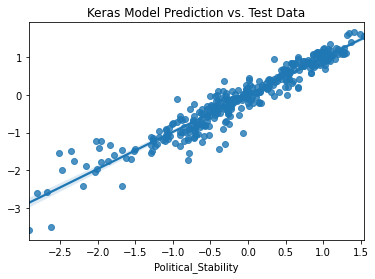

In [443]:
#Make scatterplot with seaborn
sns.regplot(x=y_test,
           y=y_pred).set_title('Keras Model Prediction vs. Test Data')

# Look at Prediction of Political Stability Using the 5-year change in each Sustainability Variable

One additional predictive feature we decided to investigate was how 5-year changes in sustainability variables over a 5-year period affected each country's level of political stabilty. For this test, we finally added the label-encoded "country" column back into the "filled_final_features" dataframe and counted the number of unique values for each country to make sure it included data for 10 years. This was true for all but one country, 159 (South Sudan), which had 9 years of data. Then we grouped the rows by country and found all of the 5-year differences. 

In [95]:
#Append Country to filled_final_features
final_with_country = filled_final_features.copy()
final_with_country['country'] = mod_df['country'].copy()
final_with_country.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",country
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,12.810347,31.237553,3.039997,56.254749,31.328545,0.63602,37.447034,10.98,6.655561,1
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,12.810347,31.237553,3.039997,56.254749,31.328545,0.63602,37.447034,11.06,6.655561,1
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,12.810347,31.237553,3.039997,56.254749,31.328545,0.64169,37.447034,11.18,6.678401,1
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,12.810347,31.237553,3.039997,56.254749,31.328545,0.64567,37.447034,11.31,6.551163,1
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,12.810347,31.237553,3.039997,56.254749,31.328545,0.64233,37.447034,11.39,9.783922,1


In [96]:
#Count number of unique values for each country to make sure it is 10 years for each country
final_with_country['country'].value_counts()
#This is true for all but one country: 159 (South Sudan) which has 9 years

#Group by the country and find the five-year difference 
five_year_change_df = final_with_country.groupby(['country']).diff(periods=5)
five_year_change_df.head(20)

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.088467,-4.45,-0.726562,0.033886,0.000000e+00,0.0,-0.004707,0.43,1.193781e+09,-1.187060,106.753113,0.00,-3.9,0.4,-0.2,0.905964,-147.4,3.874546,0.000000,0.000000,2.431211,2.371624,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01800,0.00000,0.47,3.128361
6,0.000000,-0.415770,-6.27,-7.413703,0.063565,0.000000e+00,0.0,-0.004707,0.29,2.207188e+09,4.411517,143.408883,0.00,-3.8,0.8,-0.1,1.022420,-116.4,-3.548355,0.000000,0.000000,7.340330,6.759623,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01931,0.00000,0.48,3.128361
7,0.000000,0.010995,-8.36,-0.140131,0.132023,0.000000e+00,0.0,-0.004707,0.09,1.131653e+09,10.105284,121.982525,0.00,-3.4,1.1,-0.1,0.826058,4.5,-6.909810,0.000000,214.053737,4.634454,1.465261,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.02756,0.00000,0.34,-0.427073
8,0.000000,-0.226401,-10.11,-3.562549,0.198216,0.000000e+00,0.0,0.000000,0.11,-2.134561e+08,-1.833959,81.942698,0.00,-3.1,1.5,0.1,0.378960,-322.0,2.412085,0.000000,214.053737,11.583740,7.420294,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,0.01778,0.00000,0.20,-2.463827
9,0.000000,0.353446,-9.42,-0.063564,0.064890,0.000000e+00,0.0,0.000000,0.23,-4.050537e+09,12.911127,-35.163386,0.00,-2.6,2.2,0.3,-0.320727,-122.6,17.418567,0.000000,214.053737,23.868106,2.840247,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,-0.01652,0.00000,0.13,-6.415812


Next, we added the column for our dependent variable ("Political Stability") back into the dataframe and removed sll rows that contained NaN values. We created another correlation matrix for 5-year changes in each variable relative to political stability and printed the top three positive correlations and the top three negative correlations. However, even these top correlations did not have very high correlation coefficients.

In [97]:
#Add Political Stability values to the dataframe
five_year_change_df['Political_Stability']=mod_df['Political_Stability'].copy()

In [126]:
#remove all rows with NaN values
five_year_change_df.dropna(inplace=True)
print(five_year_change_df.shape)
five_year_change_df.head(20)

(884, 34)


,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",Political_Stability
5,0.000000,0.088467,-4.45,-0.726562,0.033886,0.000000e+00,0.0,-0.004707,0.43,1.193781e+09,-1.187060,106.753113,0.00,-3.9,0.4,-0.2,0.905964,-147.4,3.874546,0.000000,0.000000,2.431211,2.371624,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01800,0.00000,0.47,3.128361,-2.411068
6,0.000000,-0.415770,-6.27,-7.413703,0.063565,0.000000e+00,0.0,-0.004707,0.29,2.207188e+09,4.411517,143.408883,0.00,-3.8,0.8,-0.1,1.022420,-116.4,-3.548355,0.000000,0.000000,7.340330,6.759623,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01931,0.00000,0.48,3.128361,-2.519349
7,0.000000,0.010995,-8.36,-0.140131,0.132023,0.000000e+00,0.0,-0.004707,0.09,1.131653e+09,10.105284,121.982525,0.00,-3.4,1.1,-0.1,0.826058,4.5,-6.909810,0.000000,214.053737,4.634454,1.465261,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.02756,0.00000,0.34,-0.427073,-2.418561
8,0.000000,-0.226401,-10.11,-3.562549,0.198216,0.000000e+00,0.0,0.000000,0.11,-2.134561e+08,-1.833959,81.942698,0.00,-3.1,1.5,0.1,0.378960,-322.0,2.412085,0.000000,214.053737,11.583740,7.420294,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,0.01778,0.00000,0.20,-2.463827,-2.502060
9,0.000000,0.353446,-9.42,-0.063564,0.064890,0.000000e+00,0.0,0.000000,0.23,-4.050537e+09,12.911127,-35.163386,0.00,-2.6,2.2,0.3,-0.320727,-122.6,17.418567,0.000000,214.053737,23.868106,2.840247,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,-0.01652,0.00000,0.13,-6.415812,-2.579152
15,-0.041460,0.836348,-3.44,0.000000,-0.132943,3.569767e-11,0.0,-0.526095,3.36,-2.058469e+09,-0.399206,-777.215801,-0.43,-2.4,2.1,0.7,0.574702,52.1,-2.802118,0.000000,0.000000,-0.300514,0.214774,-2.028816,-4.874386,-3.327237,1.263684,0.000000,7.595062,-0.04195,1.54485,6.59,1.750135,0.485986
16,-0.093412,1.865001,-5.64,0.000000,-0.285207,3.569767e-11,0.0,-0.526095,3.95,-2.370803e+09,-3.069314,-871.319323,-0.43,-2.6,2.0,0.8,0.426477,109.3,-2.604642,0.000000,0.000000,2.497112,-0.090439,-2.028816,-2.513878,-2.675220,-3.040613,0.000000,1.059608,-0.03571,2.36982,3.57,1.980792,0.091930
17,-0.145456,-0.404111,-7.46,0.000000,-0.369780,3.569767e-11,0.0,-0.526095,3.34,-6.998632e+08,-2.384671,-283.390822,-0.43,-2.6,2.2,0.5,0.307094,70.8,-2.655932,0.0444

In [99]:
#Find which feature has the highest correlation with Political Stability
#get all correlations from five_year_change_df dataframe
five_year_change_correlations = five_year_change_df.corr()
#select top 3 positive and negative correlations with political stability
five_year_top_3_pos_corrs = five_year_change_correlations['Political_Stability'].sort_values(ascending=False).head(4)
five_year_top_3_neg_corrs = five_year_change_correlations['Political_Stability'].sort_values(ascending=True).head(4)

#print out top correlations
print(five_year_top_3_pos_corrs)
print(five_year_top_3_neg_corrs)

Political_Stability                                                                                                1.000000
Commercial bank branches (per 100,000 adults)                                                                      0.310369
Literacy rate, youth female (% of females ages 15-24)                                                              0.245382
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)    0.238090
Name: Political_Stability, dtype: float64
Renewable electricity output (% of total electricity output)                   -0.194032
Terrestrial protected areas (% of total land area)                             -0.141690
Forest area (% of land area)                                                   -0.118730
Prevalence of anemia among women of reproductive age (% of women ages 15-49)   -0.113005
Name: Political_Stability, dtype: float64


0.3103690327103575


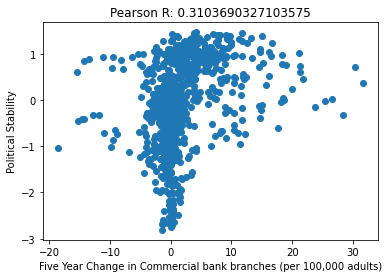

In [127]:
#Set best_corr_value
best_new_corr_value = five_year_change_df['Commercial bank branches (per 100,000 adults)'].corr(five_year_change_df['Political_Stability'])
print(best_new_corr_value)

#graph top correlation
#set x and y for scatterplot
x_five_year = five_year_change_df['Commercial bank branches (per 100,000 adults)']
y_five_year = five_year_change_df['Political_Stability']

#Use scatterplot
plt.scatter(x_five_year, y_five_year)
#add title
plt.title('Pearson R: ' + str(best_new_corr_value))
plt.xlabel("Five Year Change in Commercial bank branches (per 100,000 adults)")
plt.ylabel("Political Stability")
plt.show()

We plotted the results on a scatterplot, but there was not a strong correlation between the five-year change in each sustainability indicator and political stability score. 